<a id="contents"></a>

# Table of contents

* ### [Bathymetry ](#bathy)
* ### [Fault model](#fault)
* ### [Smaller domain simulation (setrun)](#small)
    * [Output directories (makefile)](#small_makefile)
    * [Run the simulation](#small_run)
    * [Plot results (setplot)](#small_plot)
    * [The animation](#small_animation)
    * [Fixed grids](#small_fixedgrids)
* ### [Bigger domain simulation (setrun)](#big)
    * [Output directories (makefile)](#big_makefile)
    * [Run the simulation](#big_run)
    * [Plot results (setplot)](#big_plot)
    * [The animation](#big_animation)
    * [Fixed grids](#big_fixedgrids)
* ### [Compare domains](#compare)
    * [Side by side comparison](#compare_sidebyside)
    * [Compare using the differences](#compare_differences)

<a id="bathy"></a>
# Bathymetry
[Go back to Contents](#contents)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

And download the data from the web-site.

In [2]:
from clawpack.geoclaw import topotools
import clawpack.clawutil.data as clawutildata
topo_fname = 'etopo10min120W60W60S0S.asc'
url = 'http://www.geoclaw.org/topo/etopo/' + topo_fname
clawutildata.get_remote_file(url, output_dir='.', file_name=topo_fname,
        verbose=True)

Skipping http://www.geoclaw.org/topo/etopo/etopo10min120W60W60S0S.asc 
  because file already exists: ./etopo10min120W60W60S0S.asc


Show the downloaded file header

In [3]:
!head -n 10 etopo10min120W60W60S0S.asc

361 ncols
361 nrows
-120.0 xll
-60.0 yll
0.166666666667 cellsize
999999 nodata_value
-4207.0
-4125.0
-4090.0
-3996.0


/home/jose/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/jose/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


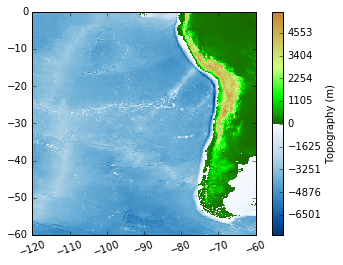

In [4]:
topo = topotools.Topography(topo_fname, topo_type=2)
topo.plot()

The bigger domain

In [5]:
from clawpack.geoclaw import topotools
import clawpack.clawutil.data as clawutildata
topo_fname2 = 'etopo10min170W60W65S25N.asc'
url = 'http://www.geoclaw.org/topo/etopo/' + topo_fname2
clawutildata.get_remote_file(url, output_dir='.', file_name=topo_fname2,
        verbose=True)

Skipping http://www.geoclaw.org/topo/etopo/etopo10min170W60W65S25N.asc 
  because file already exists: ./etopo10min170W60W65S25N.asc


And its header

In [6]:
!head -n 7 etopo10min170W60W65S25N.asc

661
541
-170.00000
-65.00000
0.16666667
-32768
  -4485  -3680  -3525  -3364  -3654  -4021  -3800  -3446  -2299  -2121   -486    -46    -13   -539  -3516  -3675  -2902  -1272  -4229  -5036  -5066  -4985  -4987  -5119  -5054  -5045  -5004  -4875  -4976  -4866  -4956  -4828  -4877  -4971  -4962  -4959  -4936  -4982  -4880  -4987  -4925  -4866  -4988  -5010  -4979  -4978  -4984  -4230  -4595  -4859  -4646  -4841  -4506  -4575  -4468  -3956  -4693  -4760  -4768  -4780  -4702  -4825  -4053  -4709  -4707  -4678  -4718  -4730  -4747  -4779  -4638  -4784  -4415  -4802  -4730  -4256  -4644  -4839  -4734  -4171  -4702  -4578  -4066  -4613  -4710  -4751  -4920  -4875  -4845  -4839  -4838  -4902  -5027  -5072  -5086  -5086  -5293  -5214  -5158  -5199  -5267  -5331  -5323  -5329  -5442  -5449  -5088  -5339  -5363  -5438  -5421  -5474  -5396  -5403  -5480  -5413  -5411  -5424  -5337  -5331  -5313  -5374  -5300  -5419  -5295  -5372  -5382  -5354  -5460  -5336  -5324  -5283  -5296  -5325  -5252  -5227 

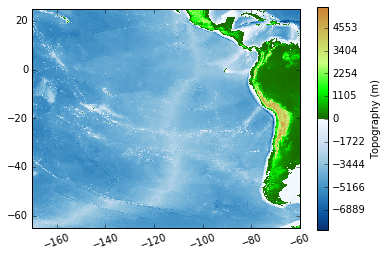

In [7]:
topo2 = topotools.Topography(topo_fname2, topo_type=3)
topo2.plot()

Notice that the header is a little weird. Better save it back in topo_type=2 (i think that is the reason it did not work before). Also, it probably has topo_type = 3, but I will work with type=2.

In [8]:
topo2.write('bigtopo.tt2',topo_type=2)
!head -7 bigtopo.tt2

   661                              ncols
   541                              nrows
-1.700000000000000e+02              xlower
-6.500000000000000e+01              ylower
 1.666666700000000e-01              cellsize
    -32768                          nodata_value
-4.485000000000000e+03


<a id="fault"></a>

# Fault model
[Go back to Contents](#contents)

In [9]:
from clawpack.geoclaw import dtopotools
fault = dtopotools.Fault()

Define a subfault

In [10]:
# Specify subfault parameters for this simple fault model consisting
# of a single subfault:
usgs_subfault = dtopotools.SubFault()
usgs_subfault.strike = 16.
usgs_subfault.length = 450.e3
usgs_subfault.width = 100.e3
usgs_subfault.depth = 35.e3
usgs_subfault.slip = 15.
usgs_subfault.rake = 104.
usgs_subfault.dip = 14.
usgs_subfault.longitude = -72.668
usgs_subfault.latitude = -35.826
usgs_subfault.coordinate_specification = "top center"

And add it to the collection of subfaults of our fault object

In [11]:
fault.subfaults = [usgs_subfault]

Now we can calculate the initial deformation of the water free surface, and write it to a file

In [12]:
import os
dtopo_fname = os.path.join('.', "dtopo_usgs100227.tt3")
if os.path.exists(dtopo_fname):
    print "*** Not regenerating dtopo file (already exists): %s" \
                % dtopo_fname
else:
    print "Using Okada model to create dtopo file"

    x = np.linspace(-77, -67, 100)
    y = np.linspace(-40, -30, 100)
    times = [1.]

    fault.create_dtopography(x,y,times)
    dtopo = fault.dtopo
    dtopo.write(dtopo_fname, dtopo_type=3)

*** Not regenerating dtopo file (already exists): ./dtopo_usgs100227.tt3


Now we can compare graphically the *slip* distribution of the fault model, with the generated vertical displacement of the free surface. In the next cell, the most important line is that which contains the *dtopo.plot_dZ_colors.*, since the others are only *matplotlib* commands to make the figure prettier or for keeping the sanity of the data.

Reading in dtopo file...


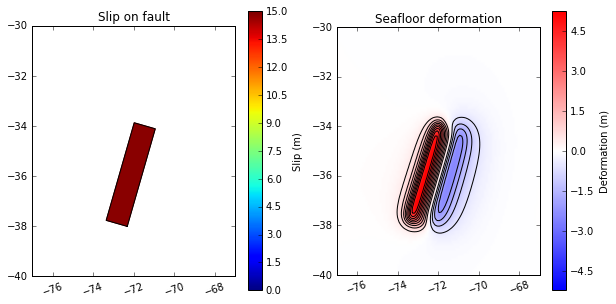

In [13]:
if fault.dtopo is None:
    # read in the pre-existing file:
    print "Reading in dtopo file..."
    dtopo = dtopotools.DTopography()
    dtopo.read(dtopo_fname, dtopo_type=3)
    x = dtopo.x
    y = dtopo.y
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fault.plot_subfaults(axes=ax1,slip_color=True)
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(y.min(),y.max())


#the important one
dtopo.plot_dZ_colors(1.,axes=ax2)

<a id="small"></a>

# Smaller domain simulation (setrun.py)
[Go back to Contents](#contents)

In [14]:
%%writefile setrun.py
# %load setrun.py
"""
Module to set up run time parameters for Clawpack.

The values set in the function setrun are then written out to data files
that will be read in by the Fortran code.

"""

import os
import numpy as np

try:
    CLAW = os.environ['CLAW']
except:
    raise Exception("*** Must first set CLAW enviornment variable")


#------------------------------
def setrun(claw_pkg='geoclaw'):
#------------------------------

    """
    Define the parameters used for running Clawpack.

    INPUT:
        claw_pkg expected to be "geoclaw" for this setrun.

    OUTPUT:
        rundata - object of class ClawRunData

    """

    from clawpack.clawutil import data

    assert claw_pkg.lower() == 'geoclaw',  "Expected claw_pkg = 'geoclaw'"

    num_dim = 2
    rundata = data.ClawRunData(claw_pkg, num_dim)


    #------------------------------------------------------------------
    # Problem-specific parameters to be written to setprob.data:
    #------------------------------------------------------------------
    
    #probdata = rundata.new_UserData(name='probdata',fname='setprob.data')


    #------------------------------------------------------------------
    # GeoClaw specific parameters:
    #------------------------------------------------------------------
    rundata = setgeo(rundata)

    #------------------------------------------------------------------
    # Standard Clawpack parameters to be written to claw.data:
    #   (or to amr2ez.data for AMR)
    #------------------------------------------------------------------
    clawdata = rundata.clawdata  # initialized when rundata instantiated


    # Set single grid parameters first.
    # See below for AMR parameters.


    # ---------------
    # Spatial domain:
    # ---------------

    # Number of space dimensions:
    clawdata.num_dim = num_dim

    # Lower and upper edge of computational domain:
    clawdata.lower[0] = -120.0      # west longitude
    clawdata.upper[0] = -60.0       # east longitude

    clawdata.lower[1] = -60.0       # south latitude
    clawdata.upper[1] = 0.0         # north latitude



    # Number of grid cells: Coarsest grid
    clawdata.num_cells[0] = 30
    clawdata.num_cells[1] = 30

    # ---------------
    # Size of system:
    # ---------------

    # Number of equations in the system:
    clawdata.num_eqn = 3

    # Number of auxiliary variables in the aux array (initialized in setaux)
    clawdata.num_aux = 4

    # Index of aux array corresponding to capacity function, if there is one:
    clawdata.capa_index = 2

    
    
    # -------------
    # Initial time:
    # -------------

    clawdata.t0 = 0.0


    # Restart from checkpoint file of a previous run?
    # Note: If restarting, you must also change the Makefile to set:
    #    RESTART = True
    # If restarting, t0 above should be from original run, and the
    # restart_file 'fort.chkNNNNN' specified below should be in 
    # the OUTDIR indicated in Makefile.

    clawdata.restart = False               # True to restart from prior results
    clawdata.restart_file = 'fort.chk00036'  # File to use for restart data

    # -------------
    # Output times:
    #--------------

    # Specify at what times the results should be written to fort.q files.
    # Note that the time integration stops after the final output time.
    # The solution at initial time t0 is always written in addition.

    clawdata.output_style = 1

    if clawdata.output_style==1:
        # Output nout frames at equally spaced times up to tfinal:
        clawdata.num_output_times = 5
        clawdata.tfinal = 10*3600.0
        clawdata.output_t0 = False  # output at initial (or restart) time?

    elif clawdata.output_style == 2:
        # Specify a list of output times.
        clawdata.output_times = [30., 60., 300., 600.]

    elif clawdata.output_style == 3:
        # Output every iout timesteps with a total of ntot time steps:
        clawdata.output_step_interval = 1
        clawdata.total_steps = 3
        clawdata.output_t0 = True
        

    clawdata.output_format = 'ascii'      # 'ascii' or 'netcdf' 

    clawdata.output_q_components = 'all'   # need all
    clawdata.output_aux_components = 'none'  # eta=h+B is in q
    clawdata.output_aux_onlyonce = False    # output aux arrays each frame



    # ---------------------------------------------------
    # Verbosity of messages to screen during integration:
    # ---------------------------------------------------

    # The current t, dt, and cfl will be printed every time step
    # at AMR levels <= verbosity.  Set verbosity = 0 for no printing.
    #   (E.g. verbosity == 2 means print only on levels 1 and 2.)
    clawdata.verbosity = 1



    # --------------
    # Time stepping:
    # --------------

    # if dt_variable==1: variable time steps used based on cfl_desired,
    # if dt_variable==0: fixed time steps dt = dt_initial will always be used.
    clawdata.dt_variable = True

    # Initial time step for variable dt.
    # If dt_variable==0 then dt=dt_initial for all steps:
    clawdata.dt_initial = 0.2

    # Max time step to be allowed if variable dt used:
    clawdata.dt_max = 1e+99

    # Desired Courant number if variable dt used, and max to allow without
    # retaking step with a smaller dt:
    clawdata.cfl_desired = 0.75
    clawdata.cfl_max = 1.0

    # Maximum number of time steps to allow between output times:
    clawdata.steps_max = 5000




    # ------------------
    # Method to be used:
    # ------------------

    # Order of accuracy:  1 => Godunov,  2 => Lax-Wendroff plus limiters
    clawdata.order = 2
    
    # Use dimensional splitting? (not yet available for AMR)
    clawdata.dimensional_split = 'unsplit'
    
    # For unsplit method, transverse_waves can be 
    #  0 or 'none'      ==> donor cell (only normal solver used)
    #  1 or 'increment' ==> corner transport of waves
    #  2 or 'all'       ==> corner transport of 2nd order corrections too
    clawdata.transverse_waves = 2

    # Number of waves in the Riemann solution:
    clawdata.num_waves = 3
    
    # List of limiters to use for each wave family:  
    # Required:  len(limiter) == num_waves
    # Some options:
    #   0 or 'none'     ==> no limiter (Lax-Wendroff)
    #   1 or 'minmod'   ==> minmod
    #   2 or 'superbee' ==> superbee
    #   3 or 'mc'       ==> MC limiter
    #   4 or 'vanleer'  ==> van Leer
    clawdata.limiter = ['mc', 'mc', 'mc']

    clawdata.use_fwaves = True    # True ==> use f-wave version of algorithms
    
    # Source terms splitting:
    #   src_split == 0 or 'none'    ==> no source term (src routine never called)
    #   src_split == 1 or 'godunov' ==> Godunov (1st order) splitting used, 
    #   src_split == 2 or 'strang'  ==> Strang (2nd order) splitting used,  not recommended.
    clawdata.source_split = 'godunov'


    # --------------------
    # Boundary conditions:
    # --------------------

    # Number of ghost cells (usually 2)
    clawdata.num_ghost = 2

    # Choice of BCs at xlower and xupper:
    #   0 => user specified (must modify bcN.f to use this option)
    #   1 => extrapolation (non-reflecting outflow)
    #   2 => periodic (must specify this at both boundaries)
    #   3 => solid wall for systems where q(2) is normal velocity

    clawdata.bc_lower[0] = 'extrap'
    clawdata.bc_upper[0] = 'extrap'

    clawdata.bc_lower[1] = 'extrap'
    clawdata.bc_upper[1] = 'extrap'



    # --------------
    # Checkpointing:
    # --------------

    # Specify when checkpoint files should be created that can be
    # used to restart a computation.

    clawdata.checkpt_style = 0

    if clawdata.checkpt_style == 0:
        # Do not checkpoint at all
        pass

    elif clawdata.checkpt_style == 1:
        # Checkpoint only at tfinal.
        pass

    elif clawdata.checkpt_style == 2:
        # Specify a list of checkpoint times.  
        clawdata.checkpt_times = [0.1,0.15]

    elif clawdata.checkpt_style == 3:
        # Checkpoint every checkpt_interval timesteps (on Level 1)
        # and at the final time.
        clawdata.checkpt_interval = 5


    # ---------------
    # AMR parameters:
    # ---------------
    amrdata = rundata.amrdata

    # max number of refinement levels:
    amrdata.amr_levels_max = 2

    # List of refinement ratios at each level (length at least mxnest-1)
    amrdata.refinement_ratios_x = [4,3]
    amrdata.refinement_ratios_y = [4,3]
    amrdata.refinement_ratios_t = [4,3]


    # Specify type of each aux variable in amrdata.auxtype.
    # This must be a list of length maux, each element of which is one of:
    #   'center',  'capacity', 'xleft', or 'yleft'  (see documentation).

    amrdata.aux_type = ['center','capacity','yleft','center']


    # Flag using refinement routine flag2refine rather than richardson error
    amrdata.flag_richardson = False    # use Richardson?
    amrdata.flag2refine = True

    # steps to take on each level L between regriddings of level L+1:
    amrdata.regrid_interval = 3

    # width of buffer zone around flagged points:
    # (typically the same as regrid_interval so waves don't escape):
    amrdata.regrid_buffer_width  = 2

    # clustering alg. cutoff for (# flagged pts) / (total # of cells refined)
    # (closer to 1.0 => more small grids may be needed to cover flagged cells)
    amrdata.clustering_cutoff = 0.700000

    # print info about each regridding up to this level:
    amrdata.verbosity_regrid = 0  

    #  ----- For developers ----- 
    # Toggle debugging print statements:
    amrdata.dprint = False      # print domain flags
    amrdata.eprint = False      # print err est flags
    amrdata.edebug = False      # even more err est flags
    amrdata.gprint = False      # grid bisection/clustering
    amrdata.nprint = False      # proper nesting output
    amrdata.pprint = False      # proj. of tagged points
    amrdata.rprint = False      # print regridding summary
    amrdata.sprint = False      # space/memory output
    amrdata.tprint = True       # time step reporting each level
    amrdata.uprint = False      # update/upbnd reporting
    
    # More AMR parameters can be set -- see the defaults in pyclaw/data.py

    # ---------------
    # Regions:
    # ---------------
    rundata.regiondata.regions = []
    # to specify regions of refinement append lines of the form
    #  [minlevel,maxlevel,t1,t2,x1,x2,y1,y2]
    rundata.regiondata.regions.append([3, 3, 0., 1e9, -360,360,-90,90])
#     rundata.regiondata.regions.append([3, 3, 0., 600., -76,-72,-38,-33])

    # ---------------
    # Gauges:
    # ---------------
    rundata.gaugedata.gauges = []
    # for gauges append lines of the form  [gaugeno, x, y, t1, t2]
    rundata.gaugedata.gauges.append([32412, -86.392, -17.975, 0., 1.e10])
    

    return rundata
    # end of function setrun
    # ----------------------


#-------------------
def setgeo(rundata):
#-------------------
    """
    Set GeoClaw specific runtime parameters.
    For documentation see ....
    """

    try:
        geo_data = rundata.geo_data
    except:
        print "*** Error, this rundata has no geo_data attribute"
        raise AttributeError("Missing geo_data attribute")
       
    # == Physics ==
    geo_data.gravity = 9.81
    geo_data.coordinate_system = 2
    geo_data.earth_radius = 6367.5e3

    # == Forcing Options
    geo_data.coriolis_forcing = False

    # == Algorithm and Initial Conditions ==
    geo_data.sea_level = 0.0
    geo_data.dry_tolerance = 1.e-3
    geo_data.friction_forcing = True
    geo_data.manning_coefficient =.025
    geo_data.friction_depth = 1e6

    # Refinement settings
    refinement_data = rundata.refinement_data
    refinement_data.variable_dt_refinement_ratios = True
    refinement_data.wave_tolerance = 1.e-2
    refinement_data.deep_depth = 1e2
    refinement_data.max_level_deep = 3

    # == settopo.data values ==
    topo_data = rundata.topo_data
    # for topography, append lines of the form
    #    [topotype, minlevel, maxlevel, t1, t2, fname]
    topo_path = './etopo10min120W60W60S0S.asc'
    topo_data.topofiles.append([2, 1, 3, 0., 1.e10, topo_path])

    # == setdtopo.data values ==
    dtopo_data = rundata.dtopo_data
    # for moving topography, append lines of the form :   (<= 1 allowed for now!)
    #   [topotype, minlevel,maxlevel,fname]
    dtopo_path = './dtopo_usgs100227.tt3'
    dtopo_data.dtopofiles.append([3,3,3,dtopo_path])
    dtopo_data.dt_max_dtopo = 0.2


    # == setqinit.data values ==
    rundata.qinit_data.qinit_type = 0
    rundata.qinit_data.qinitfiles = []
    # for qinit perturbations, append lines of the form: (<= 1 allowed for now!)
    #   [minlev, maxlev, fname]

    # == setfixedgrids.data values ==
    fixed_grids = rundata.fixed_grid_data
    fixed_grids.fixedgrids.append([0,10*3600,41,-120,-60,-60,0,100,100,0,0])
    # for fixed grids append lines of the form
    # [t1,t2,noutput,x1,x2,y1,y2,xpoints,ypoints,\
    #  ioutarrivaltimes,ioutsurfacemax]

    # == fgmax.data values ==
    fgmax_files = rundata.fgmax_data.fgmax_files
    # for fixed grids append to this list names of any fgmax input files
#     fgmax_files.append('fgmax_grid.txt')
#     rundata.fgmax_data.num_fgmax_val = 1  # Save depth only



    return rundata
    # end of function setgeo
    # ----------------------



if __name__ == '__main__':
    # Set up run-time parameters and write all data files.
    import sys
    rundata = setrun(*sys.argv[1:])
    rundata.write()



Overwriting setrun.py


Setup output directories in Makefile

<a id="small_makefile"></a>

## Output directories (makefile)
Setup output directories in Makefile, to avoid conflicts with the [bigger domain simulation](#big).

[Go back to Contents](#contents)

In [15]:
%%writefile Makefile
# Makefile for Clawpack code in this directory.
# This version only sets the local files and frequently changed
# options, and then includes the standard makefile pointed to by CLAWMAKE.
CLAWMAKE = $(CLAW)/clawutil/src/Makefile.common

# See the above file for details and a list of make options, or type
#   make .help
# at the unix prompt.


# Adjust these variables if desired:
# ----------------------------------

CLAW_PKG = geoclaw                  # Clawpack package to use
EXE = xgeoclaw                 # Executable to create
SETRUN_FILE = setrun.py        # File containing function to make data
OUTDIR = _output               # Directory for output
SETPLOT_FILE = setplot.py      # File containing function to set plots
PLOTDIR = _plots               # Directory for plots

RESTART = False

# Environment variable FC should be set to fortran compiler, e.g. gfortran

# Compiler flags can be specified here or set as an environment variable
FFLAGS ?=

# ---------------------------------
# List of sources for this program:
# ---------------------------------

AMRLIB = $(CLAW)/amrclaw/src/2d
GEOLIB = $(CLAW)/geoclaw/src/2d/shallow

MODULES = \
 $(GEOLIB)/utility_module.f90 \
 $(AMRLIB)/amr_module.f90 \
 $(AMRLIB)/regions_module.f90 \
 $(GEOLIB)/geoclaw_module.f90 \
 $(GEOLIB)/gauges_module.f90 \
 $(GEOLIB)/topo_module.f90 \
 $(GEOLIB)/qinit_module.f90 \
 $(GEOLIB)/refinement_module.f90 \
 $(GEOLIB)/fixedgrids_module.f90 \
 $(GEOLIB)/fgmax_module.f90 \
 $(GEOLIB)/surge/holland_storm_module.f90 \
 $(GEOLIB)/surge/stommel_storm_module.f90 \
 $(GEOLIB)/surge/constant_storm_module.f90 \
 $(GEOLIB)/surge/storm_module.f90 \
 $(GEOLIB)/friction_module.f90

SOURCES = \
  $(GEOLIB)/setprob.f90 \
  $(GEOLIB)/qinit.f90 \
  $(GEOLIB)/topo_update.f90 \
  $(GEOLIB)/cellgridintegrate2.f \
  $(GEOLIB)/topointegral.f \
  $(GEOLIB)/bilinearintegral.f \
  $(GEOLIB)/stepgrid.f \
  $(CLAW)/riemann/src/rpn2_geoclaw.f \
  $(CLAW)/riemann/src/rpt2_geoclaw.f \
  $(CLAW)/riemann/src/geoclaw_riemann_utils.f \
  $(GEOLIB)/src2.f90 \
  $(GEOLIB)/src1d.f90 \
  $(GEOLIB)/step2.f90 \
  $(GEOLIB)/flux2fw.f \
  $(GEOLIB)/qad.f \
  $(GEOLIB)/valout.f \
  $(GEOLIB)/filval.f90 \
  $(GEOLIB)/filpatch.f90 \
  $(AMRLIB)/prefilp.f90 \
  $(AMRLIB)/trimbd.f \
  $(AMRLIB)/bound.f \
  $(AMRLIB)/intfil.f \
  $(GEOLIB)/bc2amr.f \
  $(GEOLIB)/update.f \
  $(GEOLIB)/setaux.f90 \
  $(GEOLIB)/flag2refine2.f90  \
  $(AMRLIB)/flagregions2.f90  \
  $(GEOLIB)/allowflag.f90  \
  $(GEOLIB)/b4step2.f90 \
  $(GEOLIB)/upbnd.f  \
  $(GEOLIB)/tick.f \
  $(GEOLIB)/setgrd.f \
  $(GEOLIB)/gfixup.f \
  $(GEOLIB)/ginit.f \
  $(GEOLIB)/getmaxspeed.f90 \
  $(GEOLIB)/advanc.f \
  $(GEOLIB)/amr2.f90 \
  $(GEOLIB)/fgmax_read.f90 \
  $(GEOLIB)/fgmax_frompatch.f90 \
  $(GEOLIB)/fgmax_interpolate.f90 \
  $(GEOLIB)/fgmax_values.f90 \
  $(GEOLIB)/fgmax_finalize.f90 \
  $(AMRLIB)/quick_sort1.f \
  $(AMRLIB)/estdt.f \
  $(AMRLIB)/check4nans.f90 \
  $(AMRLIB)/spest2.f  \
  $(AMRLIB)/init_iflags.f \
  $(AMRLIB)/igetsp.f \
  $(AMRLIB)/reclam.f \
  $(AMRLIB)/birect.f \
  $(AMRLIB)/cleanup.f \
  $(AMRLIB)/colate2.f \
  $(AMRLIB)/errest.f \
  $(AMRLIB)/prepregstep.f \
  $(AMRLIB)/prepbigstep.f \
  $(AMRLIB)/bufnst2.f \
  $(AMRLIB)/flagger.f \
  $(AMRLIB)/flagregions.f \
  $(AMRLIB)/errf1.f \
  $(AMRLIB)/fixcapaq.f \
  $(AMRLIB)/flglvl2.f \
  $(AMRLIB)/fluxad.f \
  $(AMRLIB)/fluxsv.f \
  $(AMRLIB)/grdfit2.f \
  $(AMRLIB)/moment.f \
  $(AMRLIB)/nestck2.f \
  $(AMRLIB)/prepc.f \
  $(AMRLIB)/prepf.f \
  $(AMRLIB)/projec2.f \
  $(AMRLIB)/signs.f \
  $(AMRLIB)/findcut.f \
  $(AMRLIB)/smartbis.f \
  $(AMRLIB)/putnod.f \
  $(AMRLIB)/putsp.f \
  $(AMRLIB)/regrid.f \
  $(AMRLIB)/setuse.f \
  $(AMRLIB)/stst1.f \
  $(AMRLIB)/nodget.f \
  $(AMRLIB)/basic.f \
  $(AMRLIB)/outval.f \
  $(AMRLIB)/copysol.f \
  $(AMRLIB)/outvar.f \
  $(AMRLIB)/outmsh.f \
  $(AMRLIB)/outtre.f \
  $(AMRLIB)/domain.f  \
  $(AMRLIB)/cellave.f \
  $(AMRLIB)/fdisc.f \
  $(AMRLIB)/fss.f \
  $(AMRLIB)/zeroin.f \
  $(AMRLIB)/setflags.f \
  $(AMRLIB)/shiftset2.f \
  $(AMRLIB)/conck.f \
  $(AMRLIB)/domshrink.f \
  $(AMRLIB)/domprep.f \
  $(AMRLIB)/domup.f \
  $(AMRLIB)/domcopy.f \
  $(AMRLIB)/setdomflags.f \
  $(AMRLIB)/setIndices.f \
  $(AMRLIB)/coarseGridFlagSet.f \
  $(AMRLIB)/addflags.f \
  $(AMRLIB)/baseCheck.f \
  $(AMRLIB)/drivesort.f \
  $(AMRLIB)/flagcheck.f \
  $(AMRLIB)/domgrid.f \
  $(AMRLIB)/setPhysBndryFlags.f \
  $(AMRLIB)/griddomup.f \
  $(AMRLIB)/griddomcopy.f \
  $(AMRLIB)/griddomshrink.f \
  $(AMRLIB)/coarsen.f \
  $(AMRLIB)/auxcoarsen.f \
  $(AMRLIB)/intcopy.f \
  $(AMRLIB)/preintcopy.f \
  $(AMRLIB)/icall.f \
  $(AMRLIB)/preicall.f \
  $(AMRLIB)/inlinelimiter.f \
  $(AMRLIB)/cstore.f \
  $(AMRLIB)/saveqc.f \
  $(AMRLIB)/check.f \
  $(AMRLIB)/restrt.f \
  $(AMRLIB)/opendatafile.f \
  $(AMRLIB)/init_alloc.f90 \
  $(AMRLIB)/restrt_alloc.f90 \
  $(AMRLIB)/resize_alloc.f90

#-------------------------------------------------------------------
# Include Makefile containing standard definitions and make options:
include $(CLAWMAKE)

# Construct the topography data
.PHONY: topo all
topo: 
	python maketopo.py

all:
	$(MAKE) topo
	python make_fgmax.py
	$(MAKE) .output
	python plot_fgmax.py
	$(MAKE) plots
	$(MAKE) .htmls


Overwriting Makefile


<a id="small_run"></a>

## Run the simulation
[Go back to Contents](#contents)

In [16]:
%%capture out
!make clean
!make .output

<a id="small_plot"></a>

## Plot results

[Go back to Contents](#contents)

In [17]:
%%writefile setplot.py
# %load setplot.py

""" 
Set up the plot figures, axes, and items to be done for each frame.

This module is imported by the plotting routines and then the
function setplot is called to set the plot parameters.
    
""" 

import numpy as np
import matplotlib.pyplot as plt

from clawpack.geoclaw import topotools

try:
    TG32412 = np.loadtxt('32412_notide.txt')
except:
    print "*** Could not load DART data file"

#--------------------------
def setplot(plotdata):
#--------------------------
    
    """ 
    Specify what is to be plotted at each frame.
    Input:  plotdata, an instance of pyclaw.plotters.data.ClawPlotData.
    Output: a modified version of plotdata.
    
    """ 


    from clawpack.visclaw import colormaps, geoplot
    from numpy import linspace

    plotdata.clearfigures()  # clear any old figures,axes,items data


    # To plot gauge locations on pcolor or contour plot, use this as
    # an afteraxis function:

    def addgauges(current_data):
        from clawpack.visclaw import gaugetools
        gaugetools.plot_gauge_locations(current_data.plotdata, \
             gaugenos='all', format_string='ko', add_labels=True)
    

    #-----------------------------------------
    # Figure for surface
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Surface', figno=0)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes('pcolor')
    plotaxes.title = 'Surface'
    plotaxes.scaled = True

    def fixup(current_data):
        import pylab
        addgauges(current_data)
        t = current_data.t
        t = t / 3600.  # hours
        pylab.title('Surface at %4.2f hours' % t, fontsize=20)
        pylab.xticks(fontsize=15)
        pylab.yticks(fontsize=15)
    plotaxes.afteraxes = fixup

    # Water
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    #plotitem.plot_var = geoplot.surface
    plotitem.plot_var = geoplot.surface_or_depth
    plotitem.pcolor_cmap = geoplot.tsunami_colormap
    plotitem.pcolor_cmin = -0.2
    plotitem.pcolor_cmax = 0.2
    plotitem.add_colorbar = True
    plotitem.amr_celledges_show = [0,0,0]
    plotitem.patchedges_show = 1

    # Land
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.land
    plotitem.pcolor_cmap = geoplot.land_colors
    plotitem.pcolor_cmin = 0.0
    plotitem.pcolor_cmax = 100.0
    plotitem.add_colorbar = False
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = 1
    plotaxes.xlimits = [-120,-60]
    plotaxes.ylimits = [-60,0]

    # add contour lines of bathy if desired:
    plotitem = plotaxes.new_plotitem(plot_type='2d_contour')
    plotitem.show = False
    plotitem.plot_var = geoplot.topo
    plotitem.contour_levels = linspace(-3000,-3000,1)
    plotitem.amr_contour_colors = ['y']  # color on each level
    plotitem.kwargs = {'linestyles':'solid','linewidths':2}
    plotitem.amr_contour_show = [1,0,0]  
    plotitem.celledges_show = 0
    plotitem.patchedges_show = 0


    #-----------------------------------------
    # Figures for gauges
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Surface at gauges', figno=300, \
                    type='each_gauge')
    plotfigure.clf_each_gauge = True

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = 'auto'
    plotaxes.title = 'Surface'

    # Plot surface as blue curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 3
    plotitem.plotstyle = 'b-'

    # Plot topo as green curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.show = False

    def gaugetopo(current_data):
        q = current_data.q
        h = q[0,:]
        eta = q[3,:]
        topo = eta - h
        return topo
        
    plotitem.plot_var = gaugetopo
    plotitem.plotstyle = 'g-'

    def add_zeroline(current_data):
        from pylab import plot, legend, xticks, floor, axis, xlabel
        t = current_data.t 
        gaugeno = current_data.gaugeno

        if gaugeno == 32412:
            try:
                plot(TG32412[:,0], TG32412[:,1], 'r')
                legend(['GeoClaw','Obs'],'lower right')
            except: pass
            axis((0,t.max(),-0.3,0.3))

        plot(t, 0*t, 'k')
        n = int(floor(t.max()/3600.) + 2)
        xticks([3600*i for i in range(n)], ['%i' % i for i in range(n)])
        xlabel('time (hours)')

    plotaxes.afteraxes = add_zeroline


    #-----------------------------------------
    # Figures for fgmax - max values on fixed grids
    #-----------------------------------------
    otherfigure = plotdata.new_otherfigure(name='max amplitude and arrival times', 
                    fname='amplitude_times.png')



    #-----------------------------------------
    
    # Parameters used only when creating html and/or latex hardcopy
    # e.g., via pyclaw.plotters.frametools.printframes:

    plotdata.printfigs = True                # print figures
    plotdata.print_format = 'png'            # file format
    plotdata.print_framenos = 'all'          # list of frames to print
    plotdata.print_gaugenos = 'all'          # list of gauges to print
    plotdata.print_fignos = 'all'            # list of figures to print
    plotdata.html = True                     # create html files of plots?
    plotdata.html_homelink = '../README.html'   # pointer for top of index
    plotdata.latex = True                    # create latex file of plots?
    plotdata.latex_figsperline = 2           # layout of plots
    plotdata.latex_framesperline = 1         # layout of plots
    plotdata.latex_makepdf = False           # also run pdflatex?

    return plotdata



Overwriting setplot.py


In [18]:
%%capture out
!make plots

<a id="small_animation"></a>

## The animation
[Go back to Contents](#contents)

The animation that resulted from this *setplot.py* can be loaded here as an *iframe* element of IPython.

In [19]:
from IPython.display import IFrame
IFrame('_plots/movieframe_allframesfig0.html',width=600, height=600)

## Fixed grids
<a id="small_fixedgrids"></a>

[Go back to Contents](#contents)

In [20]:
xfgrid = np.linspace(-120,-60,100)
yfgrid = np.linspace(-60,0,100)

In [21]:
def read_frame(outdir,n):
    fname = '%s/fort.fg01_'%outdir + ('%i'%n).zfill(4)
    fgfile = open(fname)
    s = fgfile.readline()
    t = float(s.split()[0])/3600.
    fgfile.close()

    z = np.loadtxt(fname,skiprows=9)

    q = np.reshape(z[:,4],(100,100))
    return t,q

/home/jose/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)



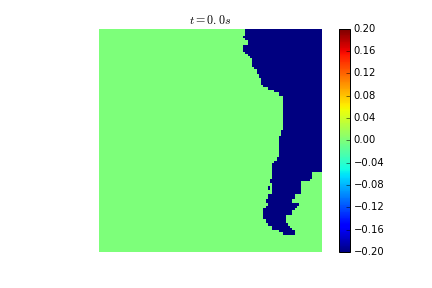
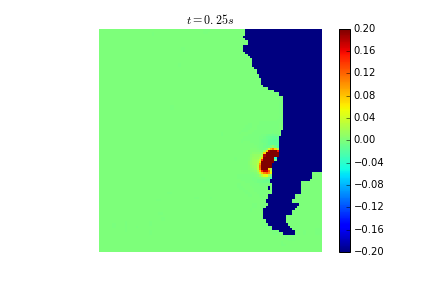
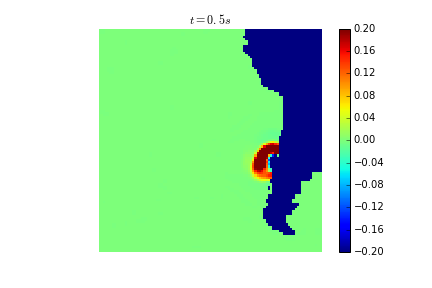
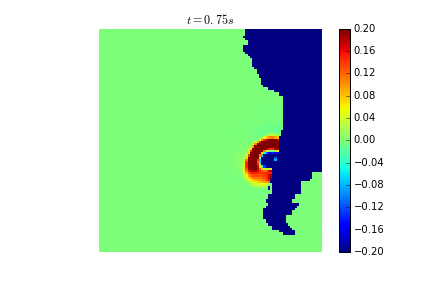
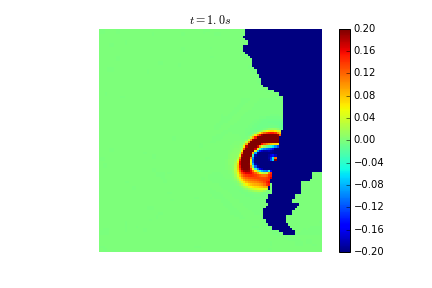
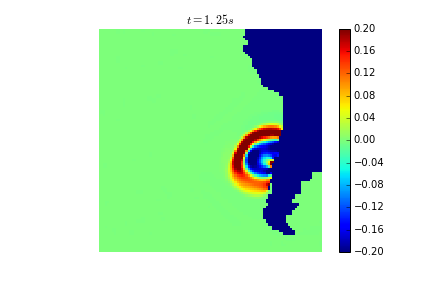
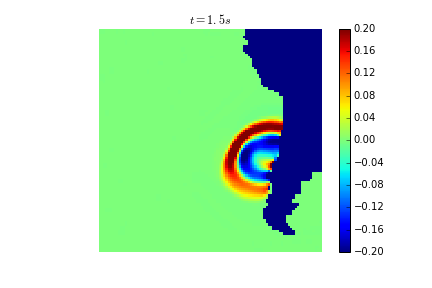
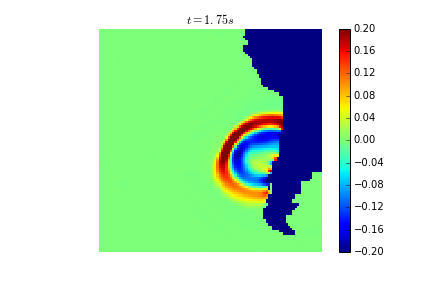
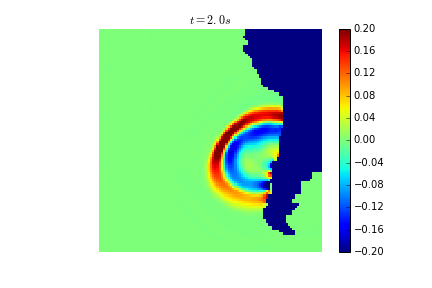
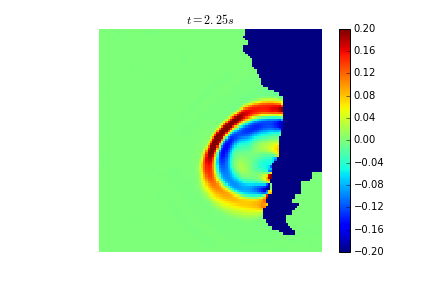
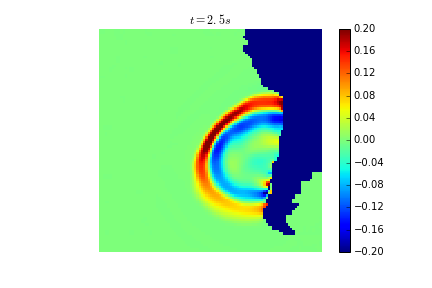
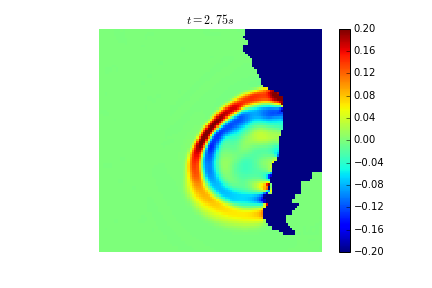
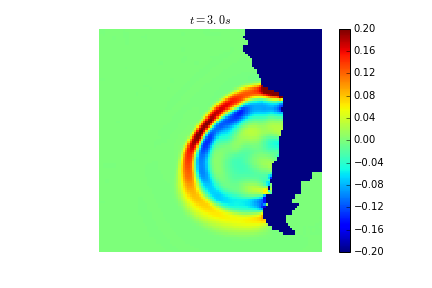
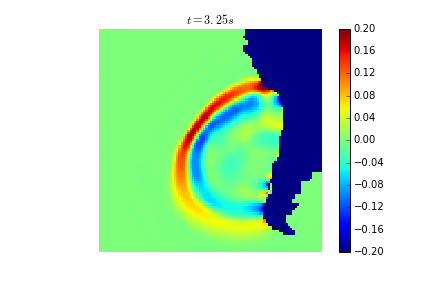
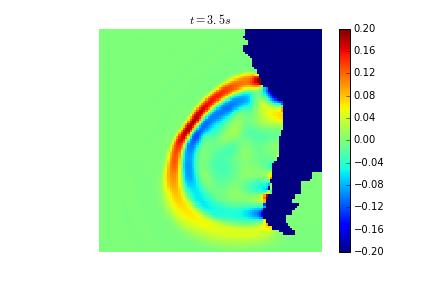
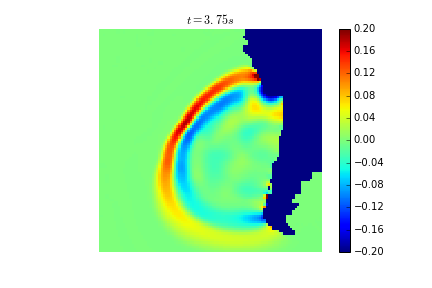
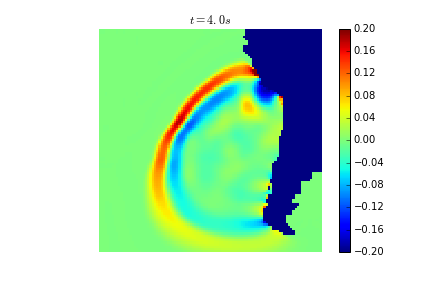
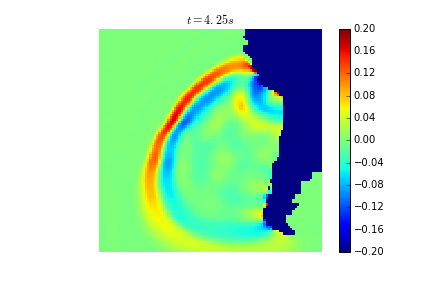
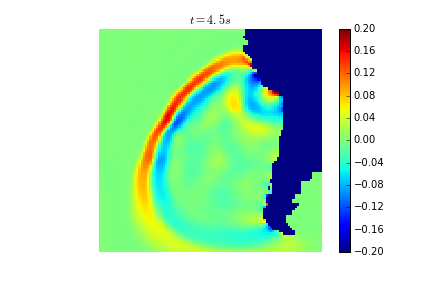
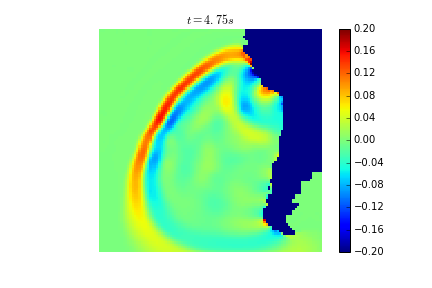
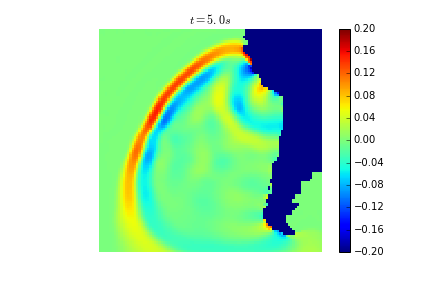
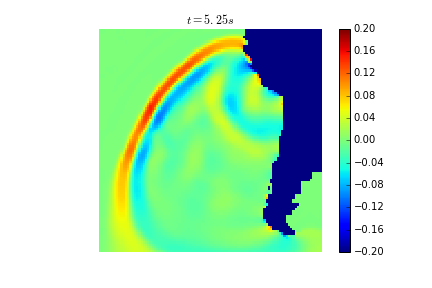
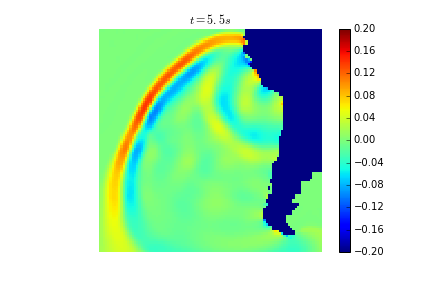
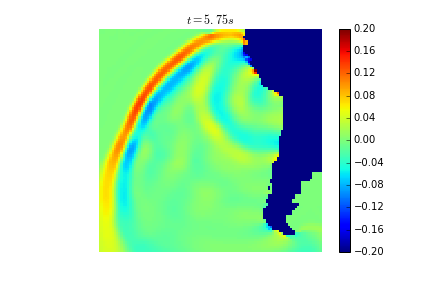
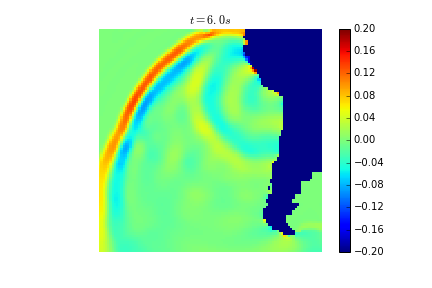
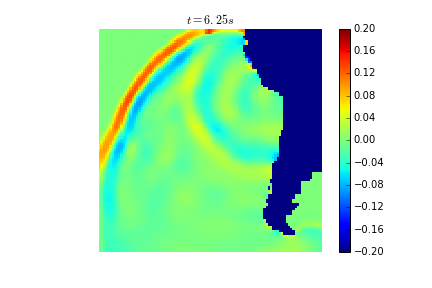
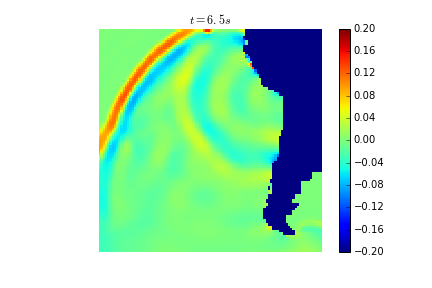
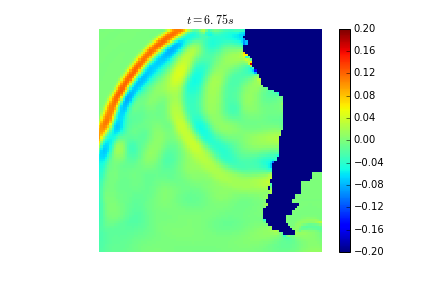
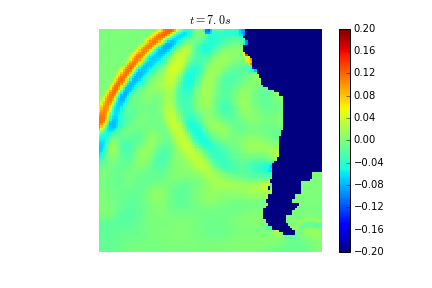
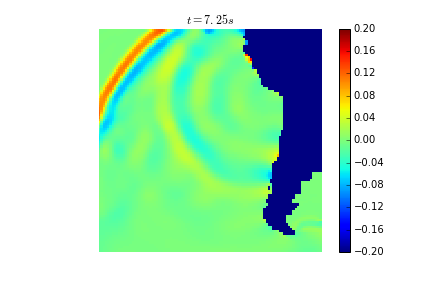
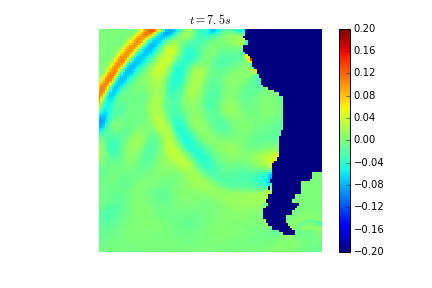
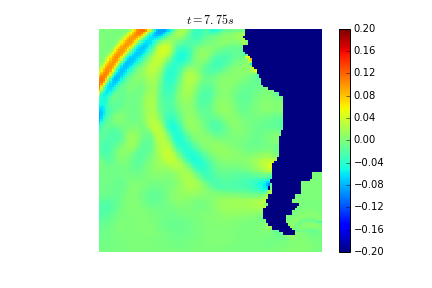
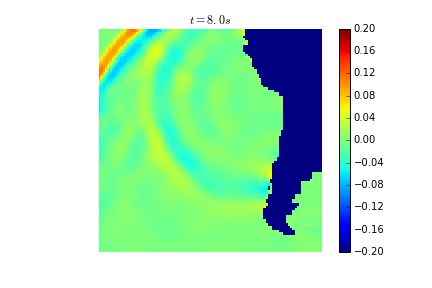
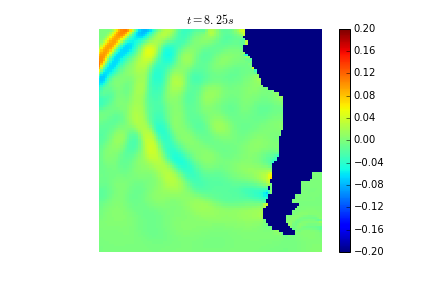
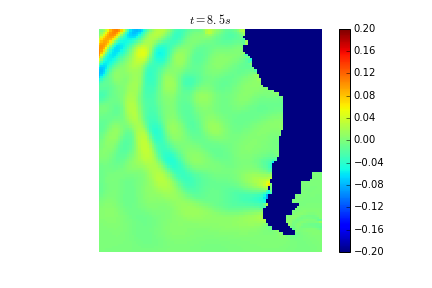
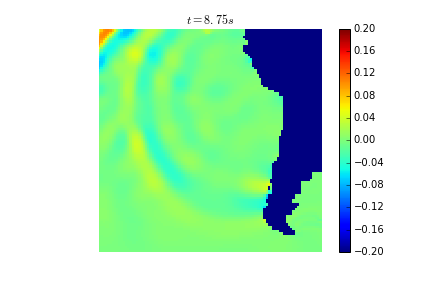
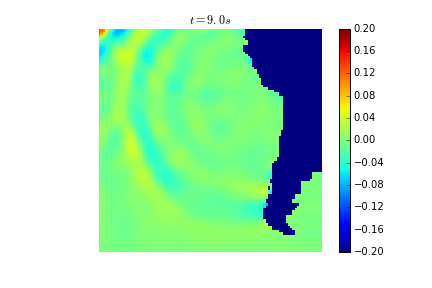
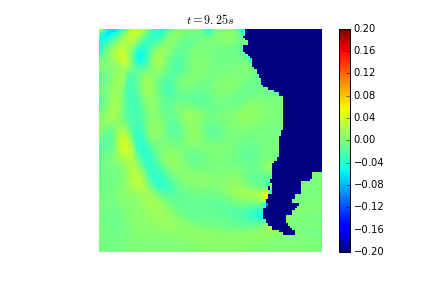
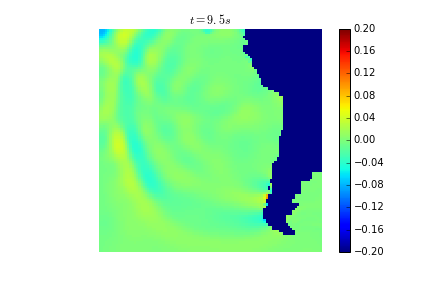
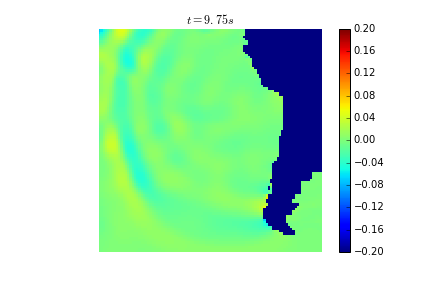

In [22]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 100), ylim=(0,100))
t,z = read_frame('_output',1)
p = ax.pcolormesh(z,vmin=-0.2,vmax=0.2)
ax.set_ylabel(r'$lon$')
ax.set_xlabel(r'$lat')
title = ax.set_title(r'$t=0.0 s$')
ax.set_axis_off()
fig.colorbar(p)
ax.set_aspect(1)



def animate(i):
    t,z = read_frame('_output',i+1)
    p.set_array(z.ravel())
    title.set_text(r'$t=%s s$'%t)
    return p,

animation.FuncAnimation(fig, animate, frames=40, interval=100)

<a id="big"></a>

# Bigger domain simulation

[Go back to Contents](#contents)

In [23]:
%%writefile setrun.py
# %load setrun.py
"""
Module to set up run time parameters for Clawpack.

The values set in the function setrun are then written out to data files
that will be read in by the Fortran code.

"""

import os
import numpy as np

try:
    CLAW = os.environ['CLAW']
except:
    raise Exception("*** Must first set CLAW enviornment variable")


#------------------------------
def setrun(claw_pkg='geoclaw'):
#------------------------------

    """
    Define the parameters used for running Clawpack.

    INPUT:
        claw_pkg expected to be "geoclaw" for this setrun.

    OUTPUT:
        rundata - object of class ClawRunData

    """

    from clawpack.clawutil import data

    assert claw_pkg.lower() == 'geoclaw',  "Expected claw_pkg = 'geoclaw'"

    num_dim = 2
    rundata = data.ClawRunData(claw_pkg, num_dim)


    #------------------------------------------------------------------
    # Problem-specific parameters to be written to setprob.data:
    #------------------------------------------------------------------
    
    #probdata = rundata.new_UserData(name='probdata',fname='setprob.data')


    #------------------------------------------------------------------
    # GeoClaw specific parameters:
    #------------------------------------------------------------------
    rundata = setgeo(rundata)

    #------------------------------------------------------------------
    # Standard Clawpack parameters to be written to claw.data:
    #   (or to amr2ez.data for AMR)
    #------------------------------------------------------------------
    clawdata = rundata.clawdata  # initialized when rundata instantiated


    # Set single grid parameters first.
    # See below for AMR parameters.


    # ---------------
    # Spatial domain:
    # ---------------

    # Number of space dimensions:
    clawdata.num_dim = num_dim

    # Lower and upper edge of computational domain:
    clawdata.lower[0] = -170.0      # west longitude
    clawdata.upper[0] = -60.0       # east longitude

    clawdata.lower[1] = -60.0       # south latitude
    clawdata.upper[1] = 0.0         # north latitude



    # Number of grid cells: Coarsest grid
    clawdata.num_cells[0] = int(30*(170.-60.)/(120.-60))*4
    clawdata.num_cells[1] = 30*4

    # ---------------
    # Size of system:
    # ---------------

    # Number of equations in the system:
    clawdata.num_eqn = 3

    # Number of auxiliary variables in the aux array (initialized in setaux)
    clawdata.num_aux = 4

    # Index of aux array corresponding to capacity function, if there is one:
    clawdata.capa_index = 2

    
    
    # -------------
    # Initial time:
    # -------------

    clawdata.t0 = 0.0


    # Restart from checkpoint file of a previous run?
    # Note: If restarting, you must also change the Makefile to set:
    #    RESTART = True
    # If restarting, t0 above should be from original run, and the
    # restart_file 'fort.chkNNNNN' specified below should be in 
    # the OUTDIR indicated in Makefile.

    clawdata.restart = False               # True to restart from prior results
    clawdata.restart_file = 'fort.chk00036'  # File to use for restart data

    # -------------
    # Output times:
    #--------------

    # Specify at what times the results should be written to fort.q files.
    # Note that the time integration stops after the final output time.
    # The solution at initial time t0 is always written in addition.

    clawdata.output_style = 1

    if clawdata.output_style==1:
        # Output nout frames at equally spaced times up to tfinal:
        clawdata.num_output_times = 5
        clawdata.tfinal = 10*3600.0
        clawdata.output_t0 = False  # output at initial (or restart) time?

    elif clawdata.output_style == 2:
        # Specify a list of output times.
        clawdata.output_times = [30., 60., 300., 600.]

    elif clawdata.output_style == 3:
        # Output every iout timesteps with a total of ntot time steps:
        clawdata.output_step_interval = 1
        clawdata.total_steps = 3
        clawdata.output_t0 = True
        

    clawdata.output_format = 'ascii'      # 'ascii' or 'netcdf' 

    clawdata.output_q_components = 'all'   # need all
    clawdata.output_aux_components = 'none'  # eta=h+B is in q
    clawdata.output_aux_onlyonce = False    # output aux arrays each frame



    # ---------------------------------------------------
    # Verbosity of messages to screen during integration:
    # ---------------------------------------------------

    # The current t, dt, and cfl will be printed every time step
    # at AMR levels <= verbosity.  Set verbosity = 0 for no printing.
    #   (E.g. verbosity == 2 means print only on levels 1 and 2.)
    clawdata.verbosity = 1



    # --------------
    # Time stepping:
    # --------------

    # if dt_variable==1: variable time steps used based on cfl_desired,
    # if dt_variable==0: fixed time steps dt = dt_initial will always be used.
    clawdata.dt_variable = True

    # Initial time step for variable dt.
    # If dt_variable==0 then dt=dt_initial for all steps:
    clawdata.dt_initial = 0.2

    # Max time step to be allowed if variable dt used:
    clawdata.dt_max = 1e+99

    # Desired Courant number if variable dt used, and max to allow without
    # retaking step with a smaller dt:
    clawdata.cfl_desired = 0.75
    clawdata.cfl_max = 1.0

    # Maximum number of time steps to allow between output times:
    clawdata.steps_max = 5000




    # ------------------
    # Method to be used:
    # ------------------

    # Order of accuracy:  1 => Godunov,  2 => Lax-Wendroff plus limiters
    clawdata.order = 2
    
    # Use dimensional splitting? (not yet available for AMR)
    clawdata.dimensional_split = 'unsplit'
    
    # For unsplit method, transverse_waves can be 
    #  0 or 'none'      ==> donor cell (only normal solver used)
    #  1 or 'increment' ==> corner transport of waves
    #  2 or 'all'       ==> corner transport of 2nd order corrections too
    clawdata.transverse_waves = 2

    # Number of waves in the Riemann solution:
    clawdata.num_waves = 3
    
    # List of limiters to use for each wave family:  
    # Required:  len(limiter) == num_waves
    # Some options:
    #   0 or 'none'     ==> no limiter (Lax-Wendroff)
    #   1 or 'minmod'   ==> minmod
    #   2 or 'superbee' ==> superbee
    #   3 or 'mc'       ==> MC limiter
    #   4 or 'vanleer'  ==> van Leer
    clawdata.limiter = ['mc', 'mc', 'mc']

    clawdata.use_fwaves = True    # True ==> use f-wave version of algorithms
    
    # Source terms splitting:
    #   src_split == 0 or 'none'    ==> no source term (src routine never called)
    #   src_split == 1 or 'godunov' ==> Godunov (1st order) splitting used, 
    #   src_split == 2 or 'strang'  ==> Strang (2nd order) splitting used,  not recommended.
    clawdata.source_split = 'godunov'


    # --------------------
    # Boundary conditions:
    # --------------------

    # Number of ghost cells (usually 2)
    clawdata.num_ghost = 2

    # Choice of BCs at xlower and xupper:
    #   0 => user specified (must modify bcN.f to use this option)
    #   1 => extrapolation (non-reflecting outflow)
    #   2 => periodic (must specify this at both boundaries)
    #   3 => solid wall for systems where q(2) is normal velocity

    clawdata.bc_lower[0] = 'extrap'
    clawdata.bc_upper[0] = 'extrap'

    clawdata.bc_lower[1] = 'extrap'
    clawdata.bc_upper[1] = 'extrap'



    # --------------
    # Checkpointing:
    # --------------

    # Specify when checkpoint files should be created that can be
    # used to restart a computation.

    clawdata.checkpt_style = 0

    if clawdata.checkpt_style == 0:
        # Do not checkpoint at all
        pass

    elif clawdata.checkpt_style == 1:
        # Checkpoint only at tfinal.
        pass

    elif clawdata.checkpt_style == 2:
        # Specify a list of checkpoint times.  
        clawdata.checkpt_times = [0.1,0.15]

    elif clawdata.checkpt_style == 3:
        # Checkpoint every checkpt_interval timesteps (on Level 1)
        # and at the final time.
        clawdata.checkpt_interval = 5


    # ---------------
    # AMR parameters:
    # ---------------
    amrdata = rundata.amrdata

    # max number of refinement levels:
    amrdata.amr_levels_max = 1

    # List of refinement ratios at each level (length at least mxnest-1)
    amrdata.refinement_ratios_x = [4,3]
    amrdata.refinement_ratios_y = [4,3]
    amrdata.refinement_ratios_t = [4,3]


    # Specify type of each aux variable in amrdata.auxtype.
    # This must be a list of length maux, each element of which is one of:
    #   'center',  'capacity', 'xleft', or 'yleft'  (see documentation).

    amrdata.aux_type = ['center','capacity','yleft','center']


    # Flag using refinement routine flag2refine rather than richardson error
    amrdata.flag_richardson = False    # use Richardson?
    amrdata.flag2refine = True

    # steps to take on each level L between regriddings of level L+1:
    amrdata.regrid_interval = 3

    # width of buffer zone around flagged points:
    # (typically the same as regrid_interval so waves don't escape):
    amrdata.regrid_buffer_width  = 2

    # clustering alg. cutoff for (# flagged pts) / (total # of cells refined)
    # (closer to 1.0 => more small grids may be needed to cover flagged cells)
    amrdata.clustering_cutoff = 0.700000

    # print info about each regridding up to this level:
    amrdata.verbosity_regrid = 0  

    #  ----- For developers ----- 
    # Toggle debugging print statements:
    amrdata.dprint = False      # print domain flags
    amrdata.eprint = False      # print err est flags
    amrdata.edebug = False      # even more err est flags
    amrdata.gprint = False      # grid bisection/clustering
    amrdata.nprint = False      # proper nesting output
    amrdata.pprint = False      # proj. of tagged points
    amrdata.rprint = False      # print regridding summary
    amrdata.sprint = False      # space/memory output
    amrdata.tprint = True       # time step reporting each level
    amrdata.uprint = False      # update/upbnd reporting
    
    # More AMR parameters can be set -- see the defaults in pyclaw/data.py

    # ---------------
    # Regions:
    # ---------------
    rundata.regiondata.regions = []
    # to specify regions of refinement append lines of the form
    #  [minlevel,maxlevel,t1,t2,x1,x2,y1,y2]
    rundata.regiondata.regions.append([3, 3, 0., 1e9, -360,360,-90,90])
#     rundata.regiondata.regions.append([3, 3, 0., 600., -76,-72,-38,-33])

    # ---------------
    # Gauges:
    # ---------------
    rundata.gaugedata.gauges = []
    # for gauges append lines of the form  [gaugeno, x, y, t1, t2]
    rundata.gaugedata.gauges.append([32412, -86.392, -17.975, 0., 1.e10])
    

    return rundata
    # end of function setrun
    # ----------------------


#-------------------
def setgeo(rundata):
#-------------------
    """
    Set GeoClaw specific runtime parameters.
    For documentation see ....
    """

    try:
        geo_data = rundata.geo_data
    except:
        print "*** Error, this rundata has no geo_data attribute"
        raise AttributeError("Missing geo_data attribute")
       
    # == Physics ==
    geo_data.gravity = 9.81
    geo_data.coordinate_system = 2
    geo_data.earth_radius = 6367.5e3

    # == Forcing Options
    geo_data.coriolis_forcing = False

    # == Algorithm and Initial Conditions ==
    geo_data.sea_level = 0.0
    geo_data.dry_tolerance = 1.e-3
    geo_data.friction_forcing = True
    geo_data.manning_coefficient =.025
    geo_data.friction_depth = 1e6

    # Refinement settings
    refinement_data = rundata.refinement_data
    refinement_data.variable_dt_refinement_ratios = True
    refinement_data.wave_tolerance = 1.e-2
    refinement_data.deep_depth = 1e2
    refinement_data.max_level_deep = 3

    # == settopo.data values ==
    topo_data = rundata.topo_data
    # for topography, append lines of the form
    #    [topotype, minlevel, maxlevel, t1, t2, fname]
    topo_path = './bigtopo.tt2'
    topo_data.topofiles.append([2, 1, 3, 0., 1.0e10, topo_path])

    # == setdtopo.data values ==
    dtopo_data = rundata.dtopo_data
    # for moving topography, append lines of the form :   (<= 1 allowed for now!)
    #   [topotype, minlevel,maxlevel,fname]
    dtopo_path = './dtopo_usgs100227.tt3'
    dtopo_data.dtopofiles.append([3,3,3,dtopo_path])
    dtopo_data.dt_max_dtopo = 0.2


    # == setqinit.data values ==
    rundata.qinit_data.qinit_type = 0
    rundata.qinit_data.qinitfiles = []
    # for qinit perturbations, append lines of the form: (<= 1 allowed for now!)
    #   [minlev, maxlev, fname]

    # == setfixedgrids.data values ==
    fixed_grids = rundata.fixed_grid_data
    fixed_grids.fixedgrids.append([0,10*3600,41,-120,-60,-60,0,100,100,0,0])
    # for fixed grids append lines of the form
    # [t1,t2,noutput,x1,x2,y1,y2,xpoints,ypoints,\
    #  ioutarrivaltimes,ioutsurfacemax]

    # == fgmax.data values ==
    fgmax_files = rundata.fgmax_data.fgmax_files
    # for fixed grids append to this list names of any fgmax input files
#     fgmax_files.append('fgmax_grid.txt')
#     rundata.fgmax_data.num_fgmax_val = 1  # Save depth only



    return rundata
    # end of function setgeo
    # ----------------------



if __name__ == '__main__':
    # Set up run-time parameters and write all data files.
    import sys
    rundata = setrun(*sys.argv[1:])
    rundata.write()



Overwriting setrun.py


<a id="big_makefile"></a>
Modify output and plots directories

In [24]:
%%writefile Makefile
# Makefile for Clawpack code in this directory.
# This version only sets the local files and frequently changed
# options, and then includes the standard makefile pointed to by CLAWMAKE.
CLAWMAKE = $(CLAW)/clawutil/src/Makefile.common

# See the above file for details and a list of make options, or type
#   make .help
# at the unix prompt.


# Adjust these variables if desired:
# ----------------------------------

CLAW_PKG = geoclaw                  # Clawpack package to use
EXE = xgeoclaw                 # Executable to create
SETRUN_FILE = setrun.py        # File containing function to make data
OUTDIR = _output_big               # Directory for output
SETPLOT_FILE = setplot.py      # File containing function to set plots
PLOTDIR = _plots_big               # Directory for plots

RESTART = False

# Environment variable FC should be set to fortran compiler, e.g. gfortran

# Compiler flags can be specified here or set as an environment variable
FFLAGS ?=

# ---------------------------------
# List of sources for this program:
# ---------------------------------

AMRLIB = $(CLAW)/amrclaw/src/2d
GEOLIB = $(CLAW)/geoclaw/src/2d/shallow

MODULES = \
 $(GEOLIB)/utility_module.f90 \
 $(AMRLIB)/amr_module.f90 \
 $(AMRLIB)/regions_module.f90 \
 $(GEOLIB)/geoclaw_module.f90 \
 $(GEOLIB)/gauges_module.f90 \
 $(GEOLIB)/topo_module.f90 \
 $(GEOLIB)/qinit_module.f90 \
 $(GEOLIB)/refinement_module.f90 \
 $(GEOLIB)/fixedgrids_module.f90 \
 $(GEOLIB)/fgmax_module.f90 \
 $(GEOLIB)/surge/holland_storm_module.f90 \
 $(GEOLIB)/surge/stommel_storm_module.f90 \
 $(GEOLIB)/surge/constant_storm_module.f90 \
 $(GEOLIB)/surge/storm_module.f90 \
 $(GEOLIB)/friction_module.f90

SOURCES = \
  $(GEOLIB)/setprob.f90 \
  $(GEOLIB)/qinit.f90 \
  $(GEOLIB)/topo_update.f90 \
  $(GEOLIB)/cellgridintegrate2.f \
  $(GEOLIB)/topointegral.f \
  $(GEOLIB)/bilinearintegral.f \
  $(GEOLIB)/stepgrid.f \
  $(CLAW)/riemann/src/rpn2_geoclaw.f \
  $(CLAW)/riemann/src/rpt2_geoclaw.f \
  $(CLAW)/riemann/src/geoclaw_riemann_utils.f \
  $(GEOLIB)/src2.f90 \
  $(GEOLIB)/src1d.f90 \
  $(GEOLIB)/step2.f90 \
  $(GEOLIB)/flux2fw.f \
  $(GEOLIB)/qad.f \
  $(GEOLIB)/valout.f \
  $(GEOLIB)/filval.f90 \
  $(GEOLIB)/filpatch.f90 \
  $(AMRLIB)/prefilp.f90 \
  $(AMRLIB)/trimbd.f \
  $(AMRLIB)/bound.f \
  $(AMRLIB)/intfil.f \
  $(GEOLIB)/bc2amr.f \
  $(GEOLIB)/update.f \
  $(GEOLIB)/setaux.f90 \
  $(GEOLIB)/flag2refine2.f90  \
  $(AMRLIB)/flagregions2.f90  \
  $(GEOLIB)/allowflag.f90  \
  $(GEOLIB)/b4step2.f90 \
  $(GEOLIB)/upbnd.f  \
  $(GEOLIB)/tick.f \
  $(GEOLIB)/setgrd.f \
  $(GEOLIB)/gfixup.f \
  $(GEOLIB)/ginit.f \
  $(GEOLIB)/getmaxspeed.f90 \
  $(GEOLIB)/advanc.f \
  $(GEOLIB)/amr2.f90 \
  $(GEOLIB)/fgmax_read.f90 \
  $(GEOLIB)/fgmax_frompatch.f90 \
  $(GEOLIB)/fgmax_interpolate.f90 \
  $(GEOLIB)/fgmax_values.f90 \
  $(GEOLIB)/fgmax_finalize.f90 \
  $(AMRLIB)/quick_sort1.f \
  $(AMRLIB)/estdt.f \
  $(AMRLIB)/check4nans.f90 \
  $(AMRLIB)/spest2.f  \
  $(AMRLIB)/init_iflags.f \
  $(AMRLIB)/igetsp.f \
  $(AMRLIB)/reclam.f \
  $(AMRLIB)/birect.f \
  $(AMRLIB)/cleanup.f \
  $(AMRLIB)/colate2.f \
  $(AMRLIB)/errest.f \
  $(AMRLIB)/prepregstep.f \
  $(AMRLIB)/prepbigstep.f \
  $(AMRLIB)/bufnst2.f \
  $(AMRLIB)/flagger.f \
  $(AMRLIB)/flagregions.f \
  $(AMRLIB)/errf1.f \
  $(AMRLIB)/fixcapaq.f \
  $(AMRLIB)/flglvl2.f \
  $(AMRLIB)/fluxad.f \
  $(AMRLIB)/fluxsv.f \
  $(AMRLIB)/grdfit2.f \
  $(AMRLIB)/moment.f \
  $(AMRLIB)/nestck2.f \
  $(AMRLIB)/prepc.f \
  $(AMRLIB)/prepf.f \
  $(AMRLIB)/projec2.f \
  $(AMRLIB)/signs.f \
  $(AMRLIB)/findcut.f \
  $(AMRLIB)/smartbis.f \
  $(AMRLIB)/putnod.f \
  $(AMRLIB)/putsp.f \
  $(AMRLIB)/regrid.f \
  $(AMRLIB)/setuse.f \
  $(AMRLIB)/stst1.f \
  $(AMRLIB)/nodget.f \
  $(AMRLIB)/basic.f \
  $(AMRLIB)/outval.f \
  $(AMRLIB)/copysol.f \
  $(AMRLIB)/outvar.f \
  $(AMRLIB)/outmsh.f \
  $(AMRLIB)/outtre.f \
  $(AMRLIB)/domain.f  \
  $(AMRLIB)/cellave.f \
  $(AMRLIB)/fdisc.f \
  $(AMRLIB)/fss.f \
  $(AMRLIB)/zeroin.f \
  $(AMRLIB)/setflags.f \
  $(AMRLIB)/shiftset2.f \
  $(AMRLIB)/conck.f \
  $(AMRLIB)/domshrink.f \
  $(AMRLIB)/domprep.f \
  $(AMRLIB)/domup.f \
  $(AMRLIB)/domcopy.f \
  $(AMRLIB)/setdomflags.f \
  $(AMRLIB)/setIndices.f \
  $(AMRLIB)/coarseGridFlagSet.f \
  $(AMRLIB)/addflags.f \
  $(AMRLIB)/baseCheck.f \
  $(AMRLIB)/drivesort.f \
  $(AMRLIB)/flagcheck.f \
  $(AMRLIB)/domgrid.f \
  $(AMRLIB)/setPhysBndryFlags.f \
  $(AMRLIB)/griddomup.f \
  $(AMRLIB)/griddomcopy.f \
  $(AMRLIB)/griddomshrink.f \
  $(AMRLIB)/coarsen.f \
  $(AMRLIB)/auxcoarsen.f \
  $(AMRLIB)/intcopy.f \
  $(AMRLIB)/preintcopy.f \
  $(AMRLIB)/icall.f \
  $(AMRLIB)/preicall.f \
  $(AMRLIB)/inlinelimiter.f \
  $(AMRLIB)/cstore.f \
  $(AMRLIB)/saveqc.f \
  $(AMRLIB)/check.f \
  $(AMRLIB)/restrt.f \
  $(AMRLIB)/opendatafile.f \
  $(AMRLIB)/init_alloc.f90 \
  $(AMRLIB)/restrt_alloc.f90 \
  $(AMRLIB)/resize_alloc.f90

#-------------------------------------------------------------------
# Include Makefile containing standard definitions and make options:
include $(CLAWMAKE)

# Construct the topography data
.PHONY: topo all
topo: 
	python maketopo.py

all:
	$(MAKE) topo
	python make_fgmax.py
	$(MAKE) .output
	python plot_fgmax.py
	$(MAKE) plots
	$(MAKE) .htmls


Overwriting Makefile


<a id="big_run"></a>
## Run the simulation
[Go back to Contents](#contents)


In [25]:
%%capture out
!make clean
!make .output

<a id="big_plot"></a>
## Plot results
[Go back to Contents](#contents)

In [26]:
%%writefile setplot.py

""" 
Set up the plot figures, axes, and items to be done for each frame.

This module is imported by the plotting routines and then the
function setplot is called to set the plot parameters.
    
""" 

import numpy as np
import matplotlib.pyplot as plt

from clawpack.geoclaw import topotools

try:
    TG32412 = np.loadtxt('32412_notide.txt')
except:
    print "*** Could not load DART data file"

#--------------------------
def setplot(plotdata):
#--------------------------
    
    """ 
    Specify what is to be plotted at each frame.
    Input:  plotdata, an instance of pyclaw.plotters.data.ClawPlotData.
    Output: a modified version of plotdata.
    
    """ 


    from clawpack.visclaw import colormaps, geoplot
    from numpy import linspace

    plotdata.clearfigures()  # clear any old figures,axes,items data


    # To plot gauge locations on pcolor or contour plot, use this as
    # an afteraxis function:

    def addgauges(current_data):
        from clawpack.visclaw import gaugetools
        gaugetools.plot_gauge_locations(current_data.plotdata, \
             gaugenos='all', format_string='ko', add_labels=True)
    

    #-----------------------------------------
    # Figure for surface
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Surface', figno=0)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes('pcolor')
    plotaxes.title = 'Surface'
    plotaxes.scaled = True

    def fixup(current_data):
        import pylab
        addgauges(current_data)
        t = current_data.t
        t = t / 3600.  # hours
        pylab.title('Surface at %4.2f hours' % t, fontsize=20)
        pylab.xticks(fontsize=15)
        pylab.yticks(fontsize=15)
    plotaxes.afteraxes = fixup

    # Water
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    #plotitem.plot_var = geoplot.surface
    plotitem.plot_var = geoplot.surface_or_depth
    plotitem.pcolor_cmap = geoplot.tsunami_colormap
    plotitem.pcolor_cmin = -0.2
    plotitem.pcolor_cmax = 0.2
    plotitem.add_colorbar = True
    plotitem.amr_celledges_show = [0,0,0]
    plotitem.patchedges_show = 1

    # Land
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.land
    plotitem.pcolor_cmap = geoplot.land_colors
    plotitem.pcolor_cmin = 0.0
    plotitem.pcolor_cmax = 100.0
    plotitem.add_colorbar = False
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = 1
    plotaxes.xlimits = [-170,-60]
    plotaxes.ylimits = [-60,0]

    # add contour lines of bathy if desired:
    plotitem = plotaxes.new_plotitem(plot_type='2d_contour')
    plotitem.show = False
    plotitem.plot_var = geoplot.topo
    plotitem.contour_levels = linspace(-3000,-3000,1)
    plotitem.amr_contour_colors = ['y']  # color on each level
    plotitem.kwargs = {'linestyles':'solid','linewidths':2}
    plotitem.amr_contour_show = [1,0,0]  
    plotitem.celledges_show = 0
    plotitem.patchedges_show = 0


    #-----------------------------------------
    # Figure for comparing the surface
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='SurfaceCompare', figno=1)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes('pcolor')
    plotaxes.title = 'Surface'
    plotaxes.scaled = True

    def fixup(current_data):
        import pylab
        addgauges(current_data)
        t = current_data.t
        t = t / 3600.  # hours
        pylab.title('Surface at %4.2f hours' % t, fontsize=20)
        pylab.xticks(fontsize=15)
        pylab.yticks(fontsize=15)
    plotaxes.afteraxes = fixup

    # Water
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    #plotitem.plot_var = geoplot.surface
    plotitem.plot_var = geoplot.surface_or_depth
    plotitem.pcolor_cmap = geoplot.tsunami_colormap
    plotitem.pcolor_cmin = -0.2
    plotitem.pcolor_cmax = 0.2
    plotitem.add_colorbar = True
    plotitem.amr_celledges_show = [0,0,0]
    plotitem.patchedges_show = 1

    # Land
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.land
    plotitem.pcolor_cmap = geoplot.land_colors
    plotitem.pcolor_cmin = 0.0
    plotitem.pcolor_cmax = 100.0
    plotitem.add_colorbar = False
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = 1
    plotaxes.xlimits = [-120,-60]
    plotaxes.ylimits = [-60,0]

    # add contour lines of bathy if desired:
    plotitem = plotaxes.new_plotitem(plot_type='2d_contour')
    plotitem.show = False
    plotitem.plot_var = geoplot.topo
    plotitem.contour_levels = linspace(-3000,-3000,1)
    plotitem.amr_contour_colors = ['y']  # color on each level
    plotitem.kwargs = {'linestyles':'solid','linewidths':2}
    plotitem.amr_contour_show = [1,0,0]  
    plotitem.celledges_show = 0
    plotitem.patchedges_show = 0
    
    #-----------------------------------------
    # Figures for gauges
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Surface at gauges', figno=300, \
                    type='each_gauge')
    plotfigure.clf_each_gauge = True

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = 'auto'
    plotaxes.title = 'Surface'

    # Plot surface as blue curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 3
    plotitem.plotstyle = 'b-'

    # Plot topo as green curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.show = False

    def gaugetopo(current_data):
        q = current_data.q
        h = q[0,:]
        eta = q[3,:]
        topo = eta - h
        return topo
        
    plotitem.plot_var = gaugetopo
    plotitem.plotstyle = 'g-'

    def add_zeroline(current_data):
        from pylab import plot, legend, xticks, floor, axis, xlabel
        t = current_data.t 
        gaugeno = current_data.gaugeno

        if gaugeno == 32412:
            try:
                plot(TG32412[:,0], TG32412[:,1], 'r')
                legend(['GeoClaw','Obs'],'lower right')
            except: pass
            axis((0,t.max(),-0.3,0.3))

        plot(t, 0*t, 'k')
        n = int(floor(t.max()/3600.) + 2)
        xticks([3600*i for i in range(n)], ['%i' % i for i in range(n)])
        xlabel('time (hours)')

    plotaxes.afteraxes = add_zeroline


    #-----------------------------------------
    # Figures for fgmax - max values on fixed grids
    #-----------------------------------------
    otherfigure = plotdata.new_otherfigure(name='max amplitude and arrival times', 
                    fname='amplitude_times.png')



    #-----------------------------------------
    
    # Parameters used only when creating html and/or latex hardcopy
    # e.g., via pyclaw.plotters.frametools.printframes:

    plotdata.printfigs = True                # print figures
    plotdata.print_format = 'png'            # file format
    plotdata.print_framenos = 'all'          # list of frames to print
    plotdata.print_gaugenos = 'all'          # list of gauges to print
    plotdata.print_fignos = 'all'            # list of figures to print
    plotdata.html = True                     # create html files of plots?
    plotdata.html_homelink = '../README.html'   # pointer for top of index
    plotdata.latex = True                    # create latex file of plots?
    plotdata.latex_figsperline = 2           # layout of plots
    plotdata.latex_framesperline = 1         # layout of plots
    plotdata.latex_makepdf = False           # also run pdflatex?

    return plotdata


Overwriting setplot.py


In [27]:
%%capture out
!make plots

<a id="big_animation"></a>


<a id="big_animation"></a>

## Animation

In [28]:
IFrame('_plots_big/movieframe_allframesfig0.html',width=600, height=600)

## Fixed grids
<a id="big_fixedgrids"></a>

[Go back to Contents](#contents)

I will use the functions generated in the [fixed grids of the small domain case](#small_fixedgrids).


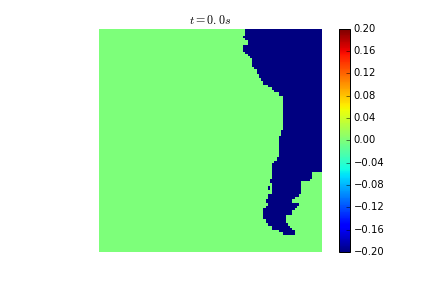
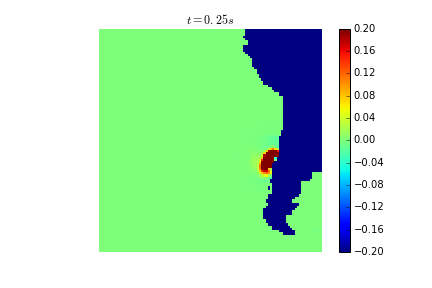
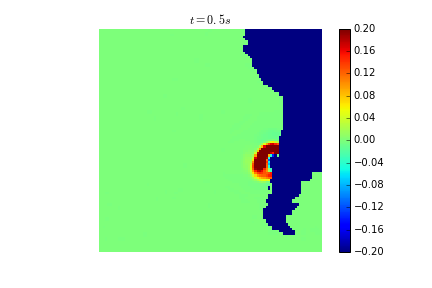
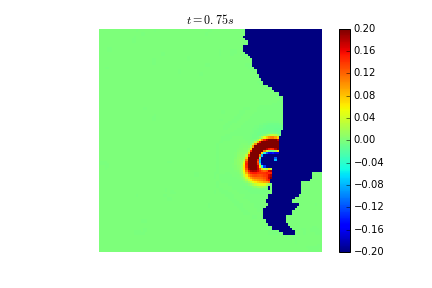
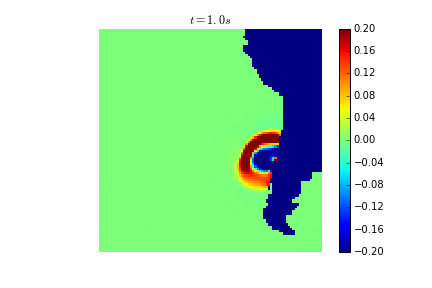
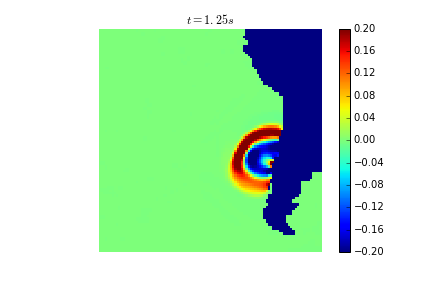
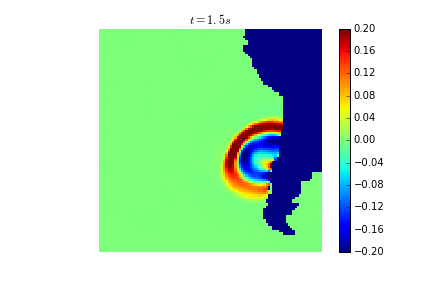
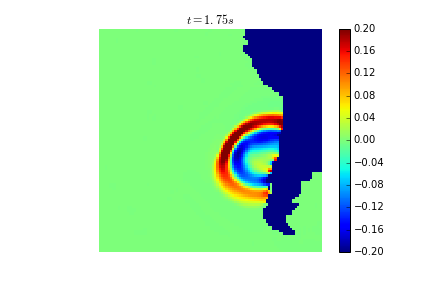
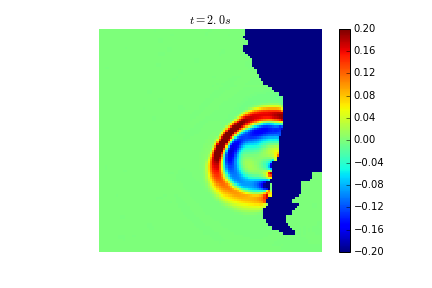
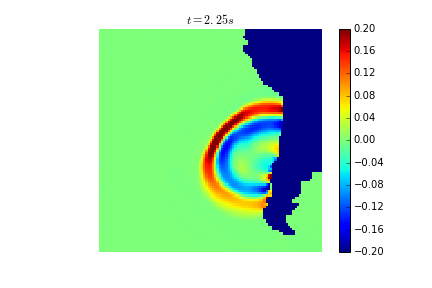
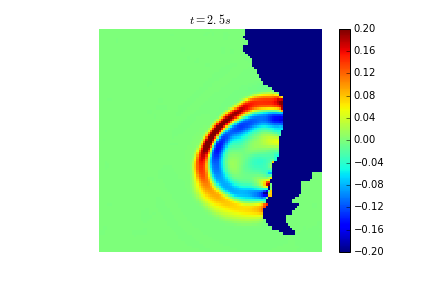
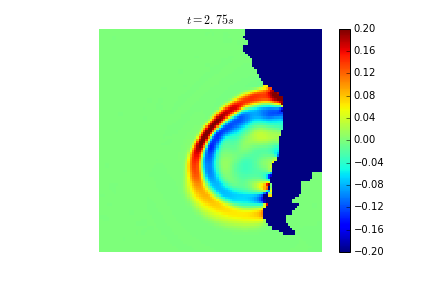
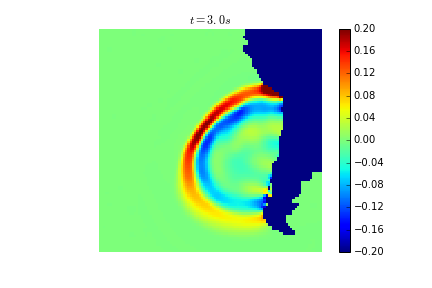
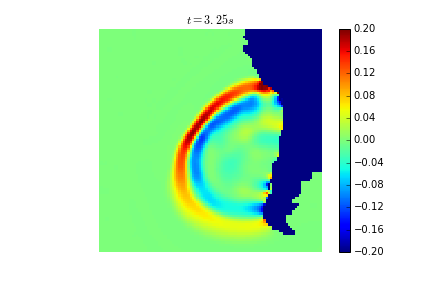
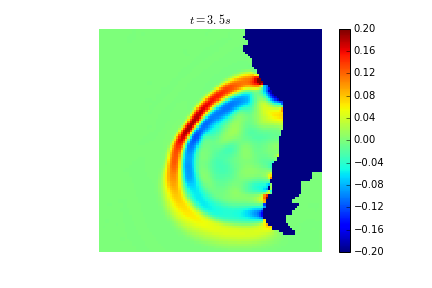
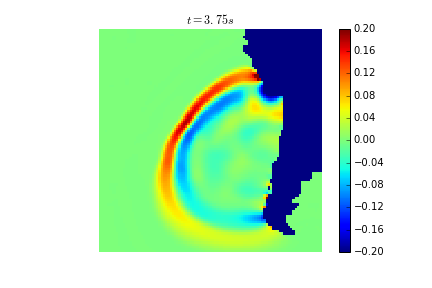
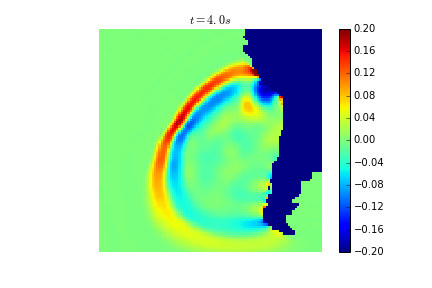
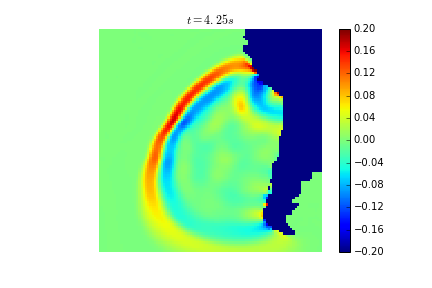
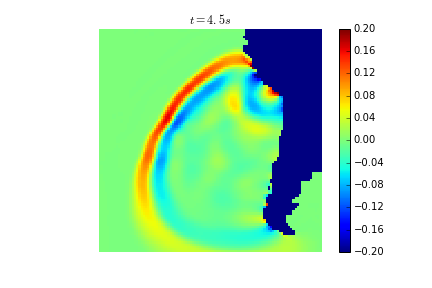
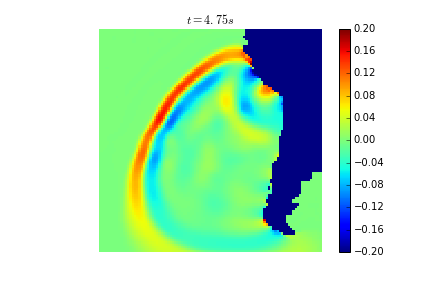
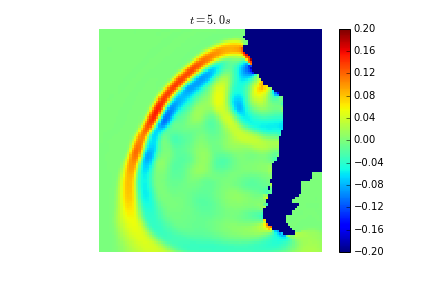
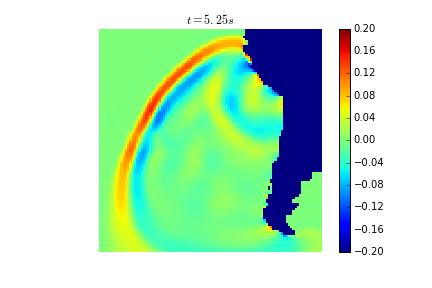
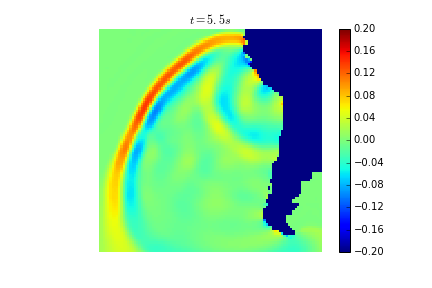
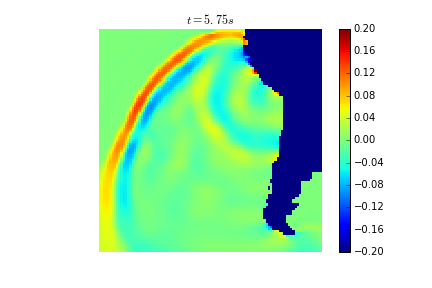
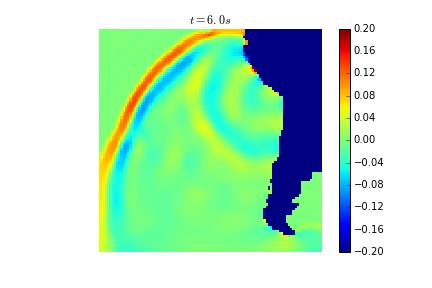
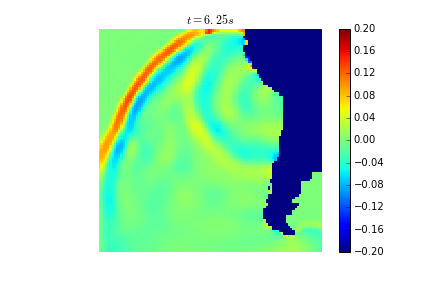
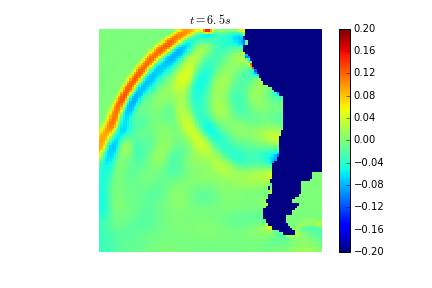
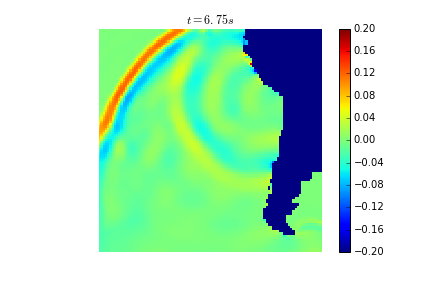
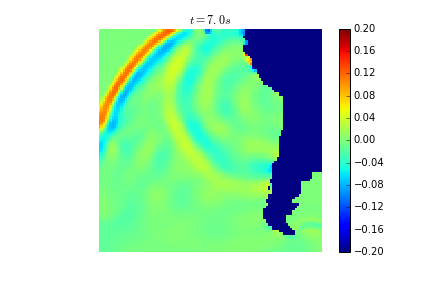
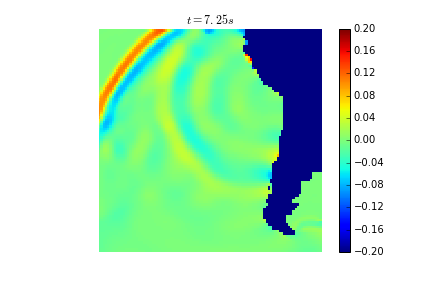
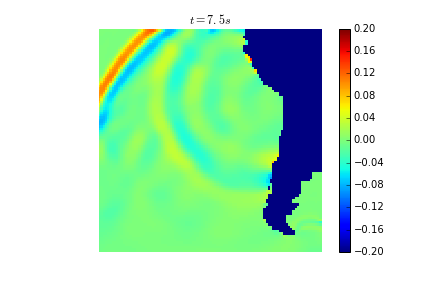
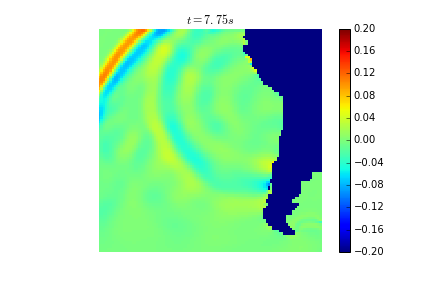
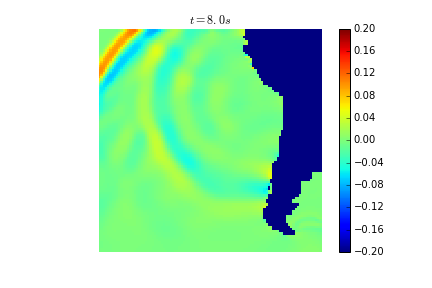
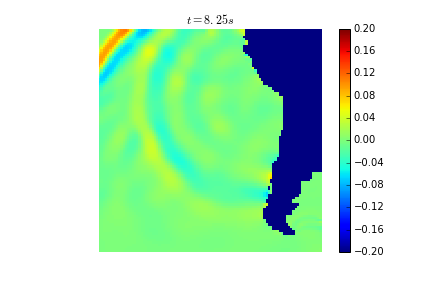
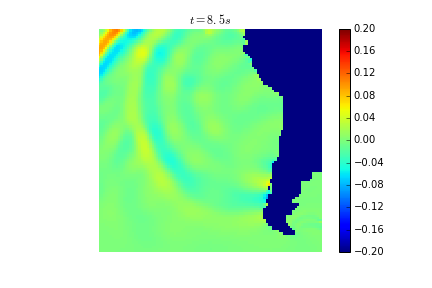
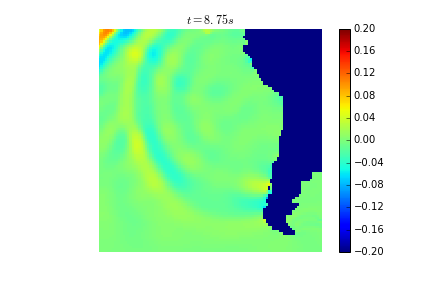
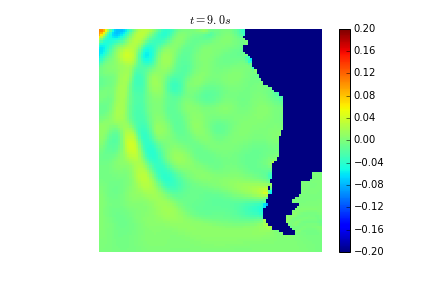
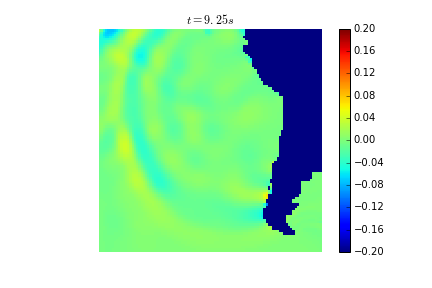
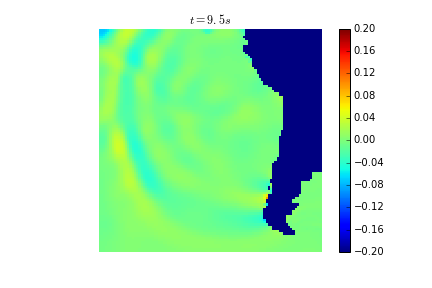
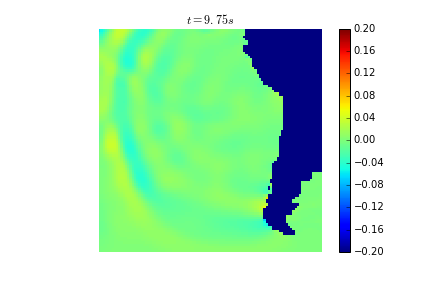

In [29]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 100), ylim=(0,100))
t,z = read_frame('_output_big',1)
p = ax.pcolormesh(z,vmin=-0.2,vmax=0.2)
ax.set_ylabel(r'$lon$')
ax.set_xlabel(r'$lat')
title = ax.set_title(r'$t=0.0 s$')
ax.set_axis_off()
fig.colorbar(p)
ax.set_aspect(1)



def animate(i):
    t,z = read_frame('_output_big',i+1)
    p.set_array(z.ravel())
    title.set_text(r'$t=%s s$'%t)
    return p,

animation.FuncAnimation(fig, animate, frames=40, interval=100)

<a id="compare"></a>

# Compare domains
[Go back to Contents](#contents)

Compare the solutions with both domains using information stored in fixed grids.

<a id="compare_sidebyside"></a>

## Side by side comparison
[Go back to Contents](#contents)


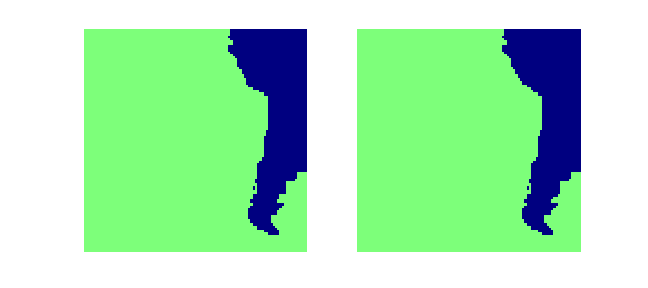
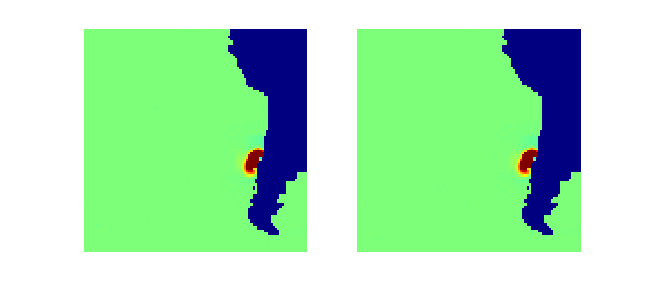
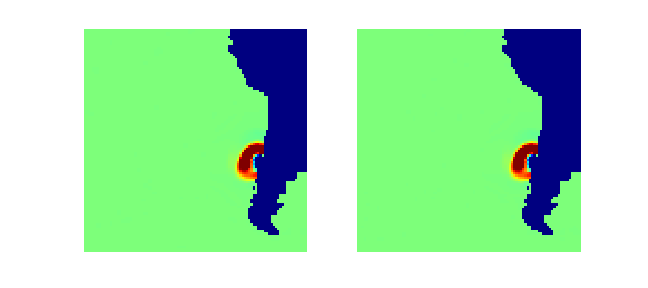
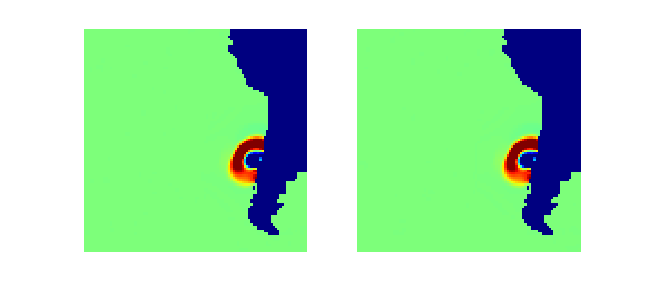
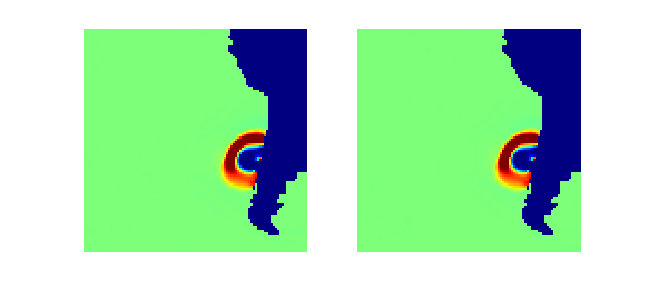
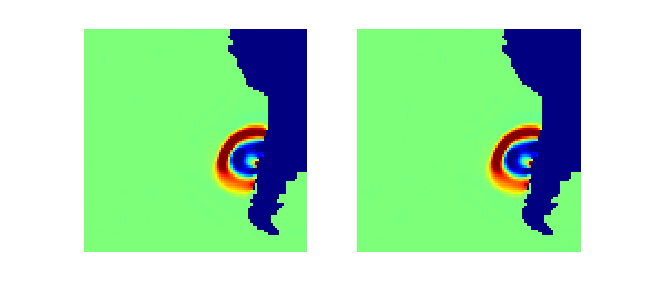
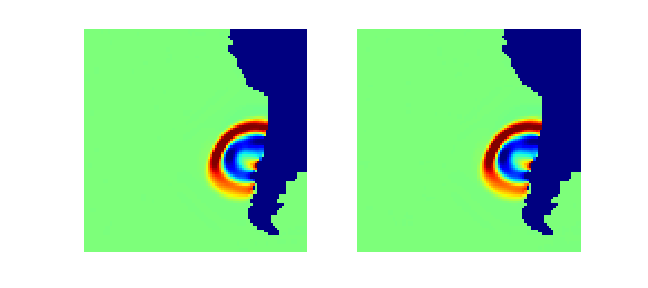
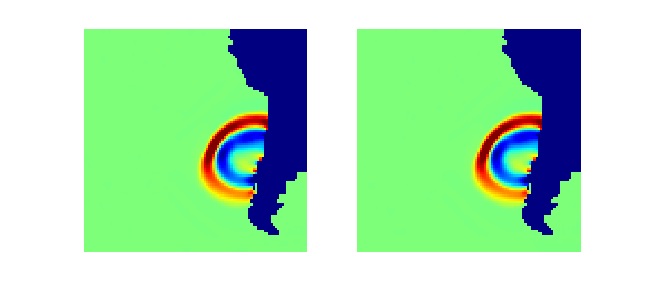
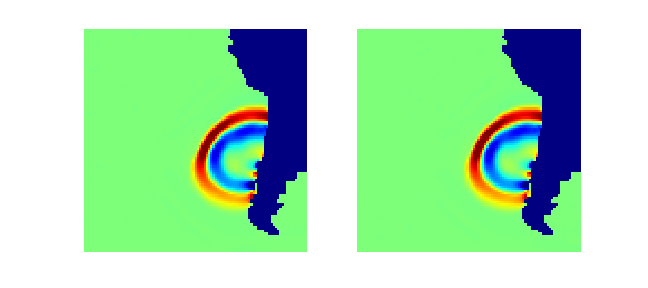
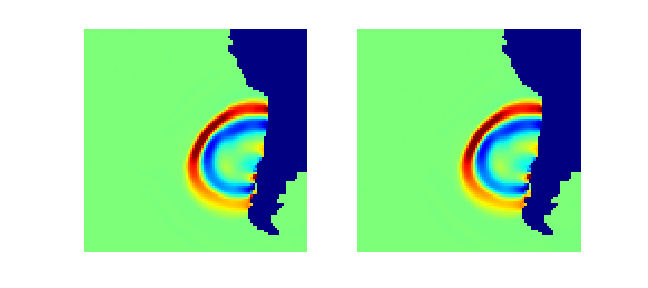
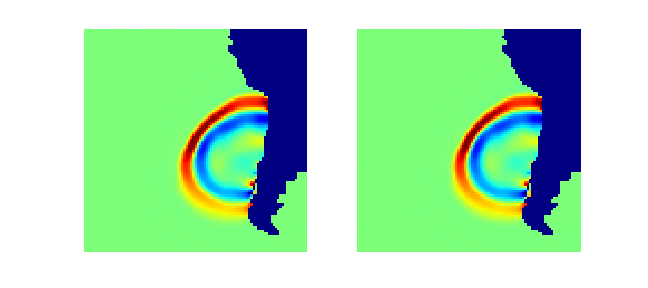
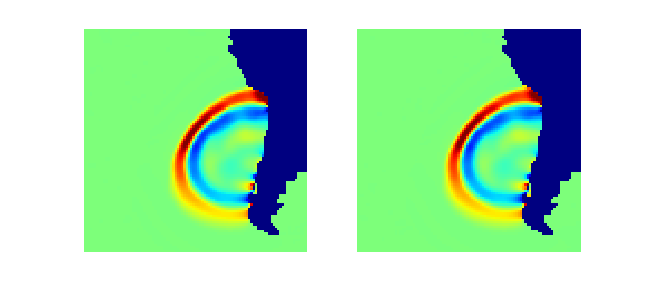
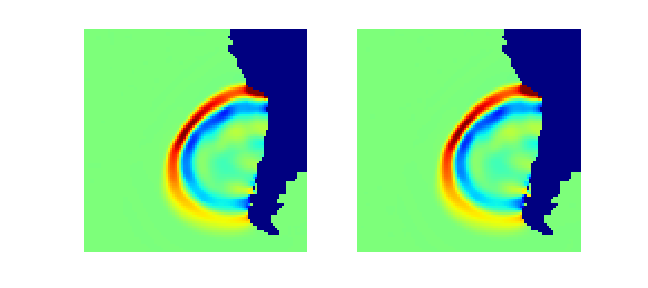
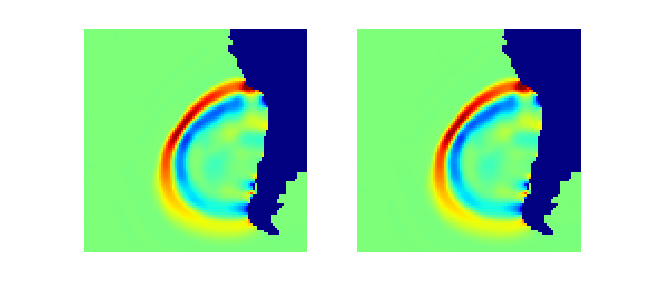
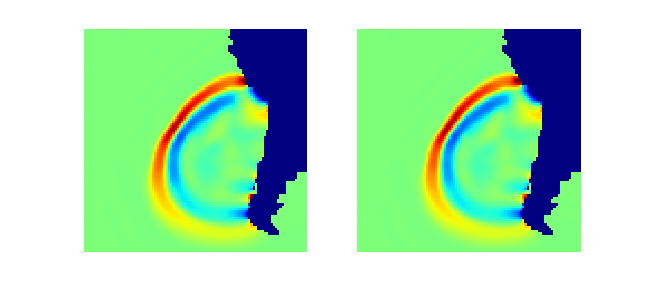
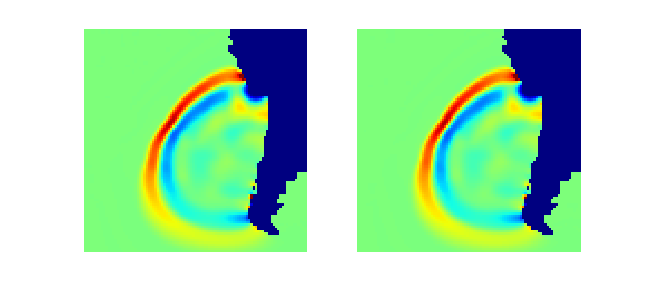
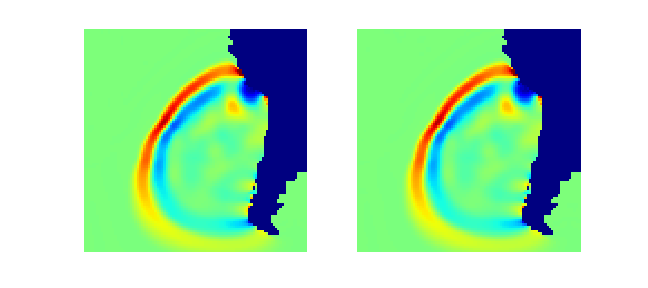
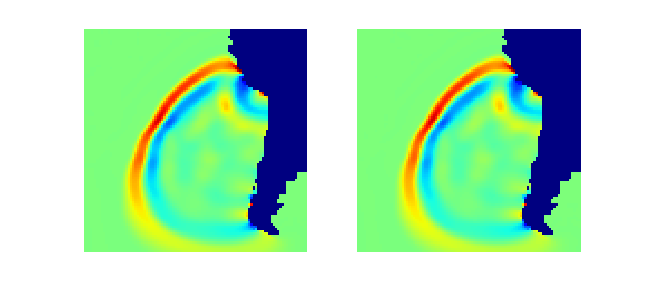
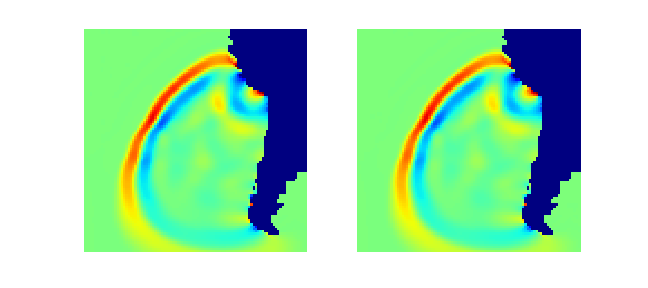
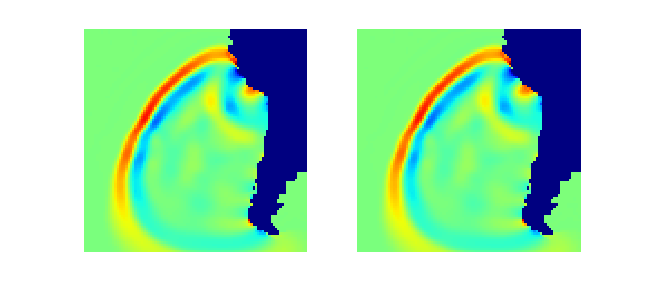
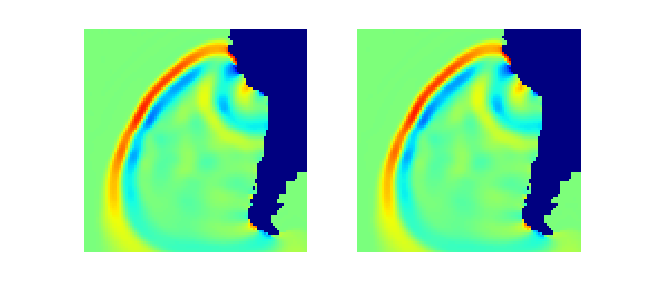
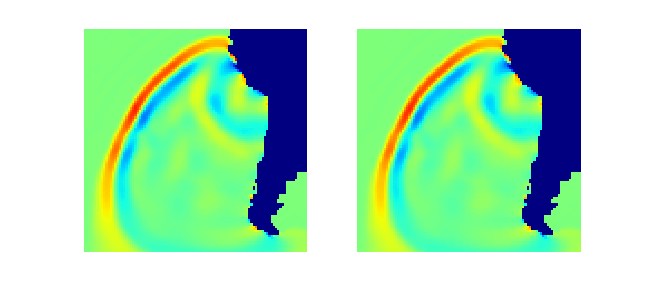
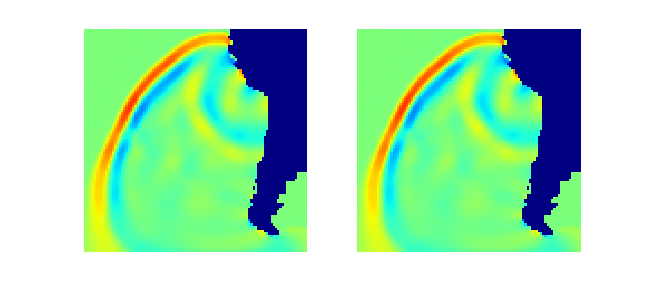
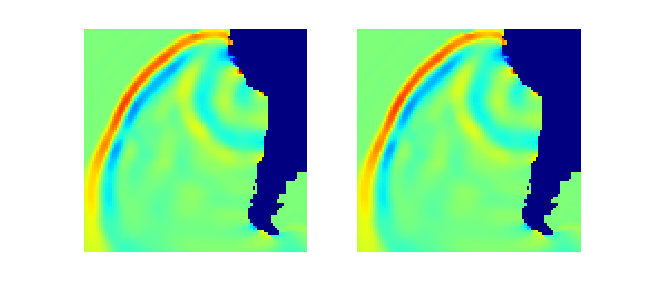
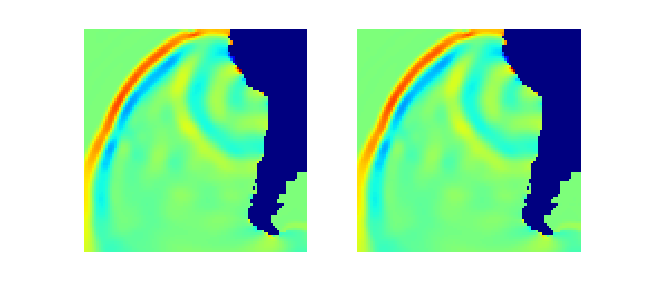
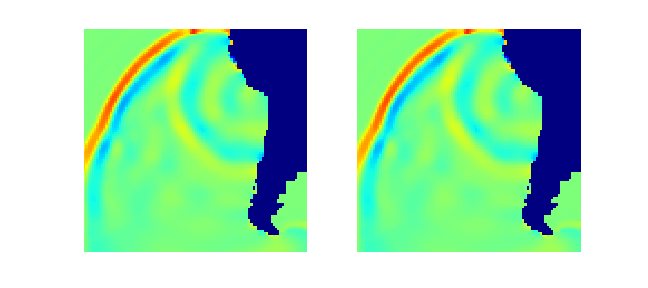
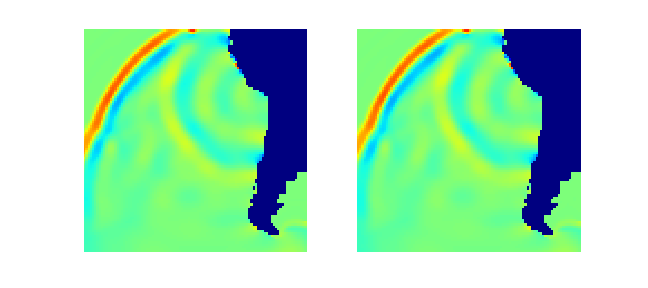
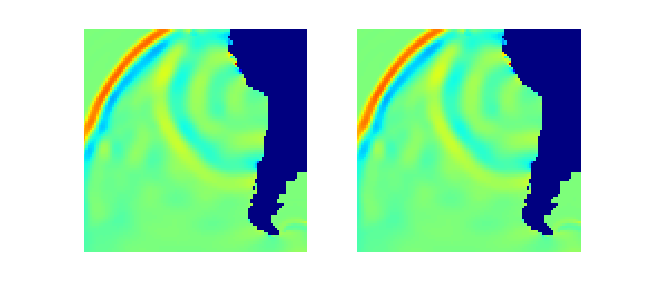
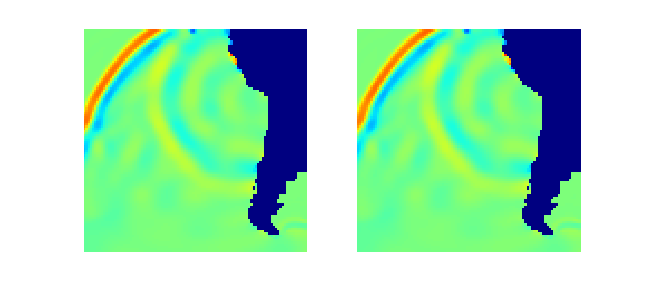
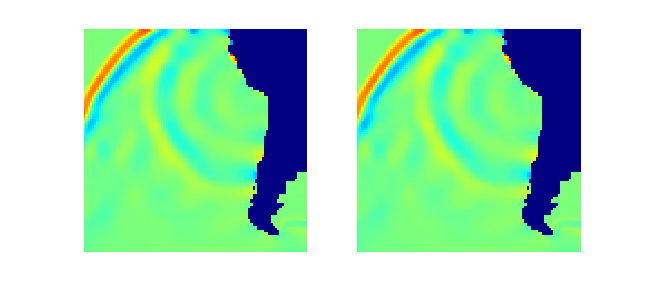
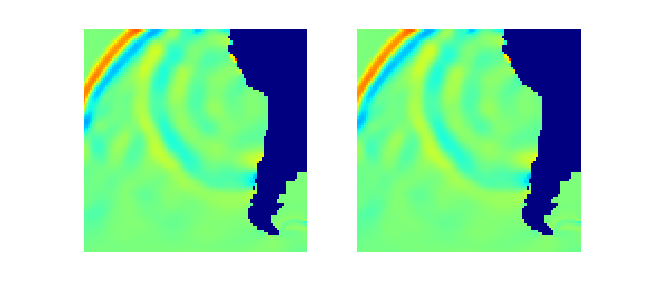
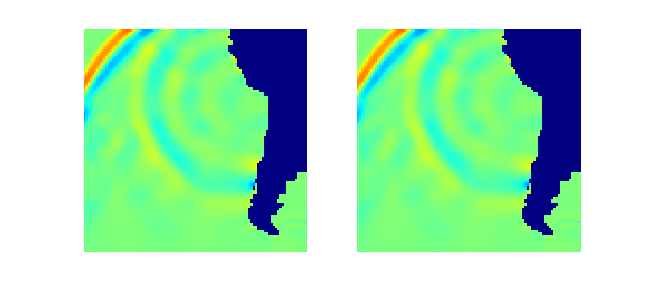
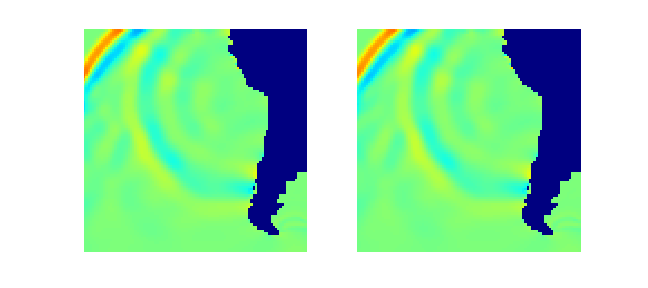
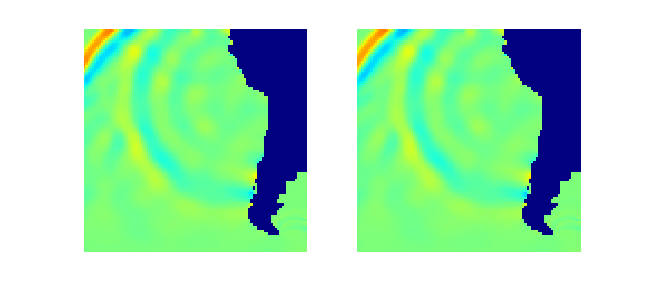
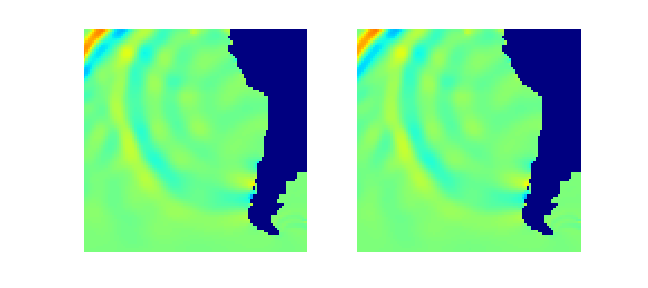
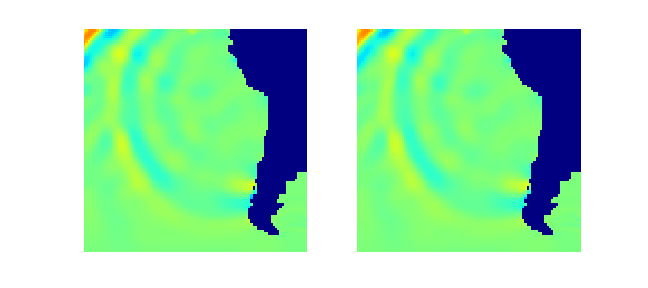
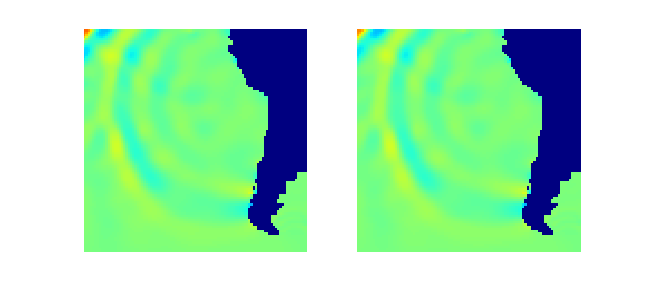
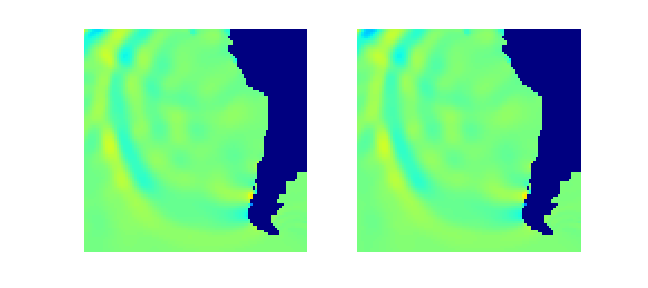
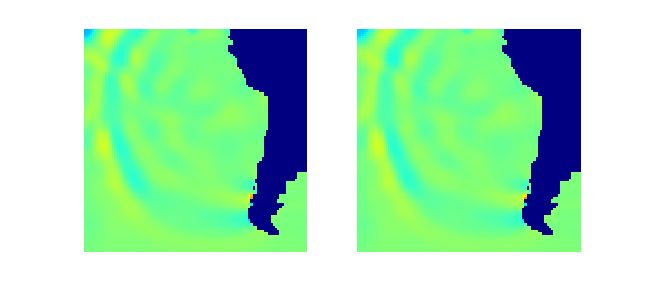
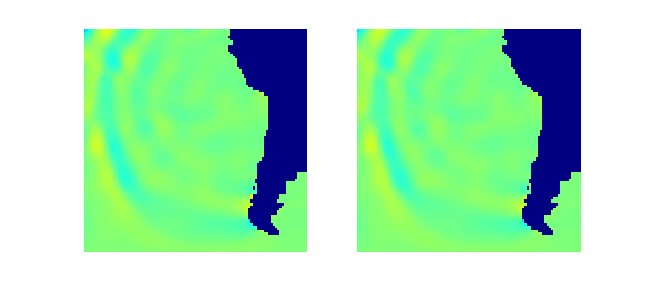

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

t,zsmall = read_frame('_output',1)
t,zbig = read_frame('_output_big',1)

fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(121)
ax1.set_xlim(0,100)
ax1.set_ylim(0,100)
psmall = ax1.pcolormesh(zsmall,vmin=-0.2,vmax=0.2)
ax1.set_axis_off()
ax1.set_aspect(1)

ax2 = fig.add_subplot(122)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)
pbig = ax2.pcolormesh(zbig,vmin=-0.2,vmax=0.2)
ax2.set_axis_off()
ax2.set_aspect(1)

def animate(i):
    t,zsmall = read_frame('_output',i+1)
    t,zbig = read_frame('_output_big',i+1)
    psmall.set_array(zsmall.ravel())
    pbig.set_array(zbig.ravel())
    title.set_text('t=%s hours'%t)
    return p,

animation.FuncAnimation(fig, animate, frames=40, interval=300)


<a id="compare_differences"></a>

## Compare using the difference
[Go back to Contents](#contents)


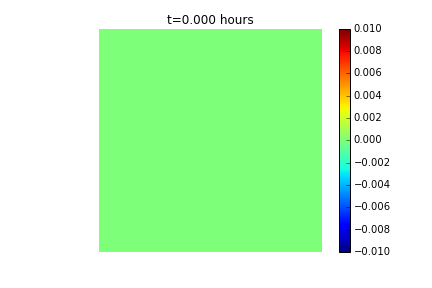
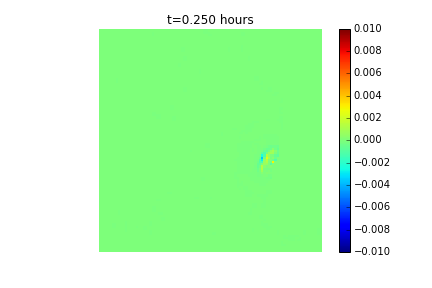
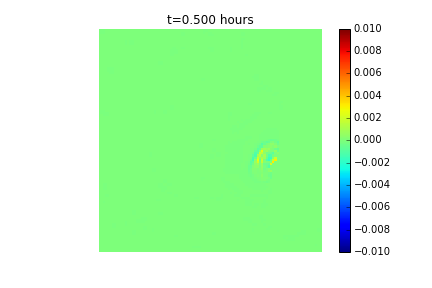
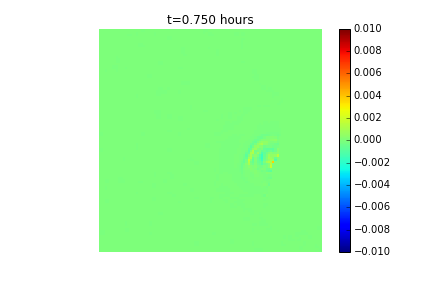
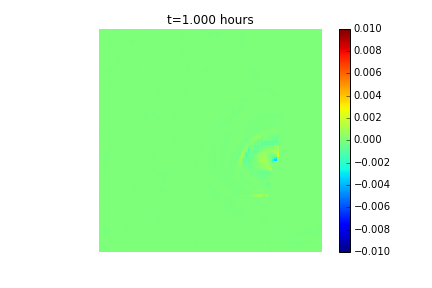
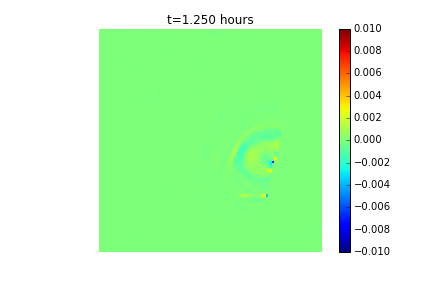
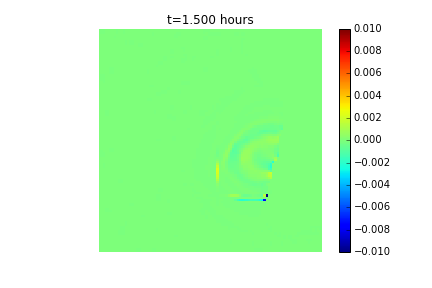
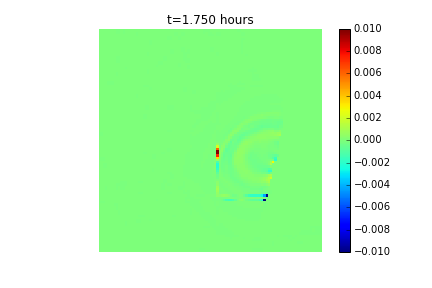
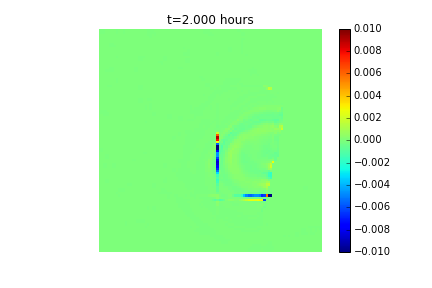
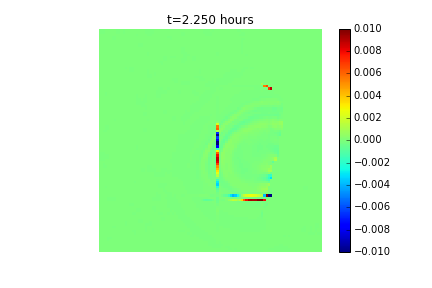
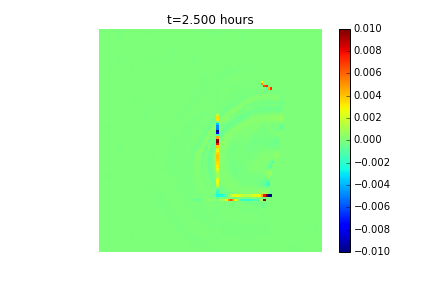
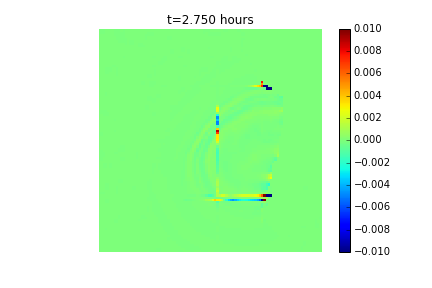
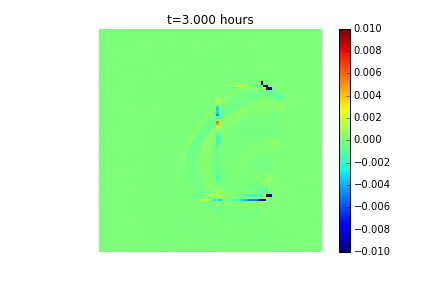
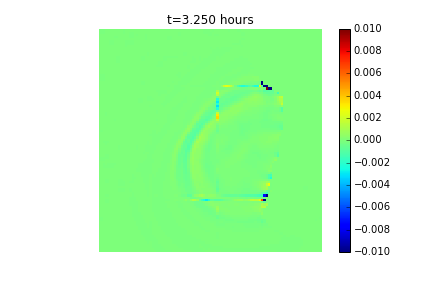
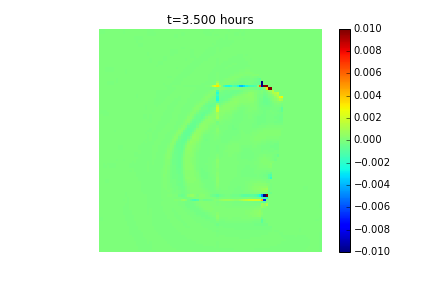
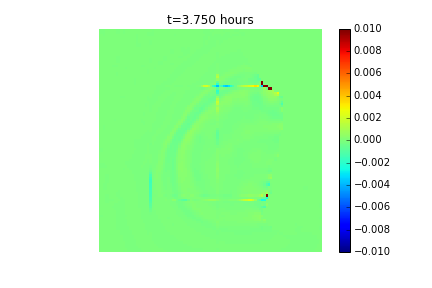
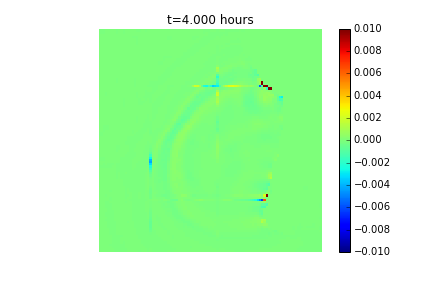
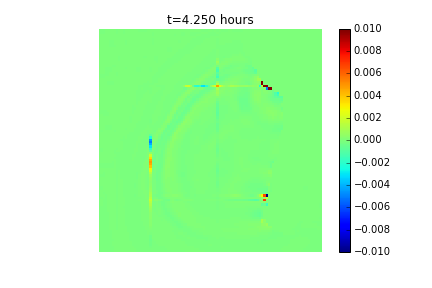
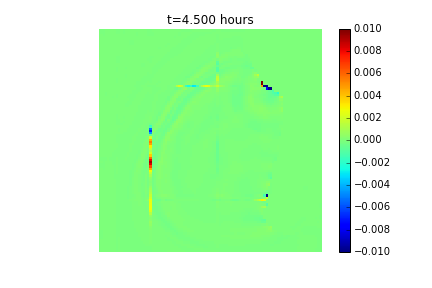
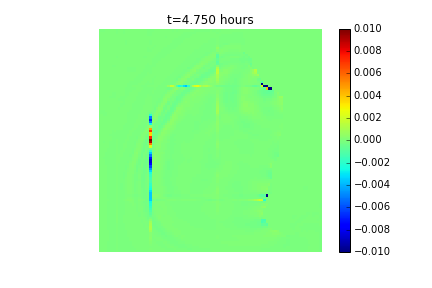
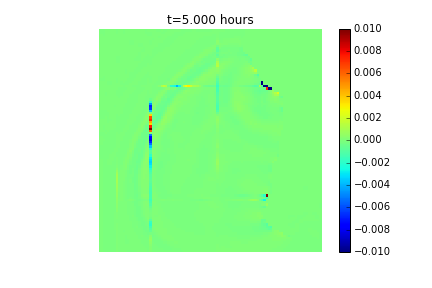
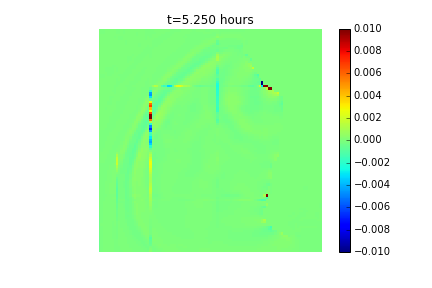
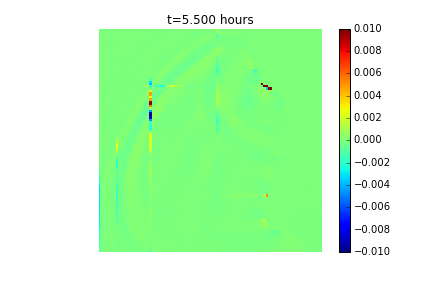
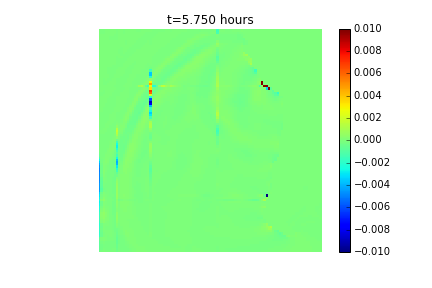
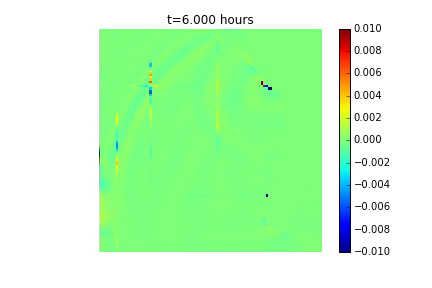
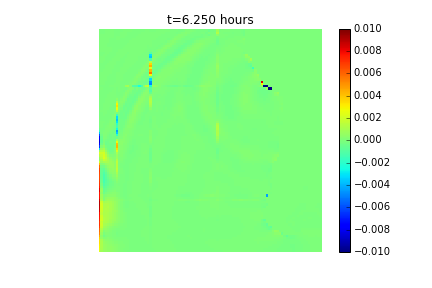
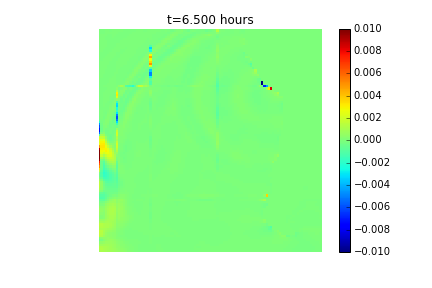
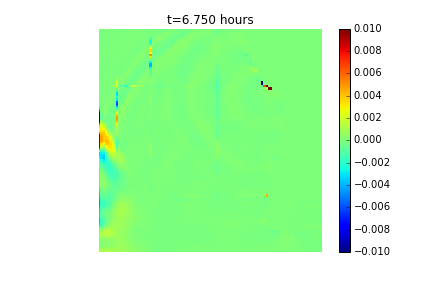
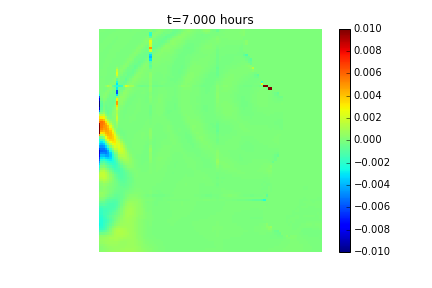
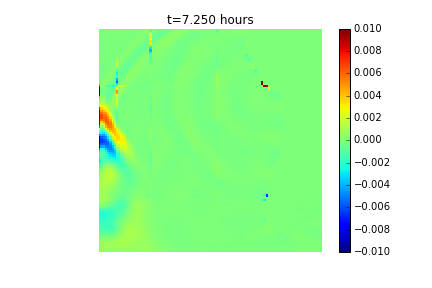
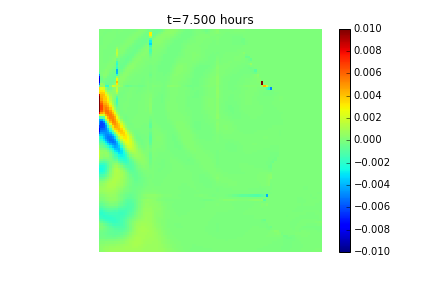
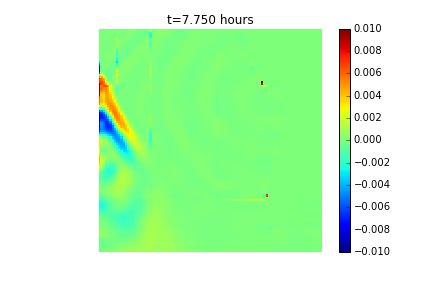
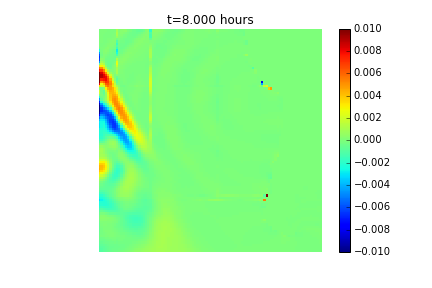
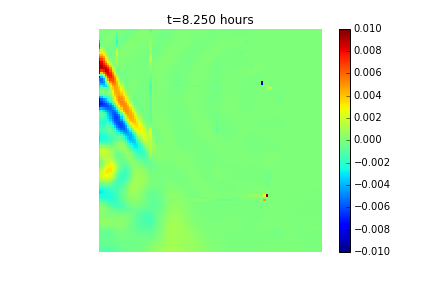
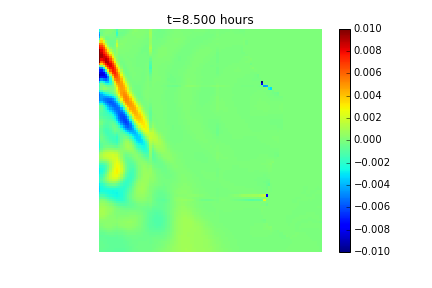
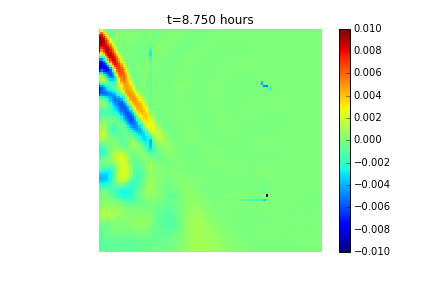
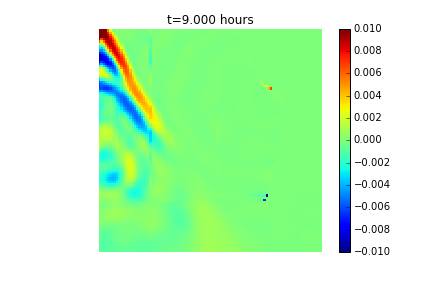
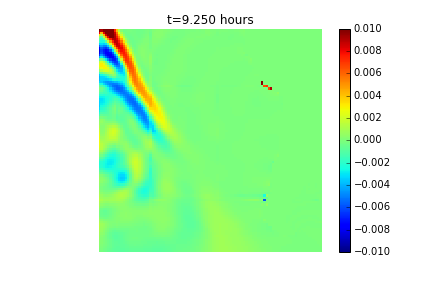
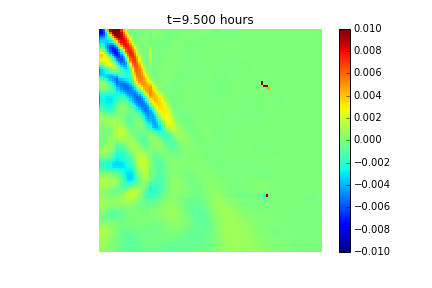
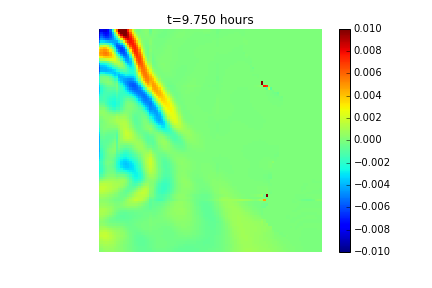

In [31]:
t,zsmall = read_frame('_output',1)
t,zbig = read_frame('_output_big',1)
zsmall = np.where(np.isnan(zsmall),0.0,zsmall)
zbig = np.where(np.isnan(zbig),0.0,zbig)
z = zsmall -zbig

fig = plt.figure()
ax = plt.axes(xlim=(0, 100), ylim=(0,100))
p = ax.pcolormesh(z,vmin=-0.01,vmax=0.01)
ax.set_ylabel(r'$lon$')
ax.set_xlabel(r'$lat')
title = ax.set_title('t=0.0 hours')
ax.set_axis_off()
fig.colorbar(p)
ax.set_aspect(1)

def animate(i):
    t,zsmall = read_frame('_output',i+1)
    t,zbig = read_frame('_output_big',i+1)
    zsmall = np.where(np.isnan(zsmall),0.0,zsmall)
    zbig = np.where(np.isnan(zbig),0.0,zbig)
    z = zsmall-zbig
    p.set_array(z.ravel())
    title.set_text('t=%.3f hours'%float(t))
    return p,

animation.FuncAnimation(fig, animate, frames=40, interval=100)